In [3]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [4]:
%cd /content/gdrive/MyDrive/ML_ITMO_24

/content/gdrive/MyDrive/ML_ITMO_24


<table width="99%"> <tr> <td bgcolor = #E6E6FA><font size=3>
<b>Предмет исследования</b></td></tr></table>
<blockquote><ul type = "square">
<li>
Важно знать, какие факторы могут вызвать проблемы на линиях электропередач, и важно предсказывать отключения для обеспечения бесперебойной работы.
</li><li>Идея состоит в том, чтобы <b>проанализировать характеристики напряжения и тока на трех фазах линий электропередачи для обнаружения неисправностей, и, если неисправность существует, мы дополнительно классифицируем ее тип, чтобы устранить проблему</b>.

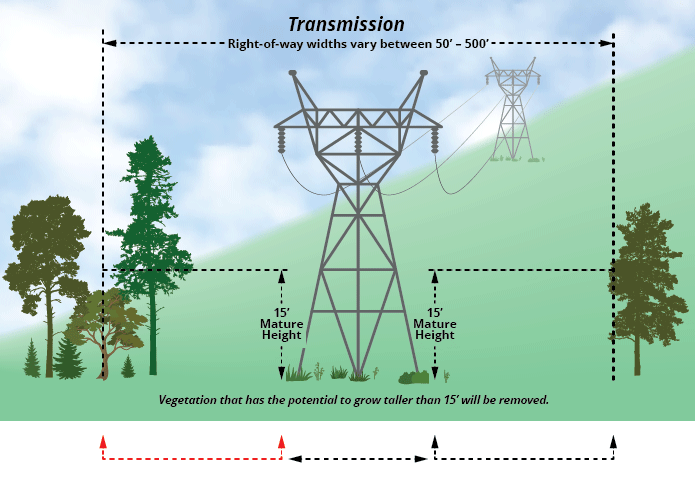

<table width="99%"> <tr> <td bgcolor = #E6E6FA><font size=3>
<b>Гипотеза</b></td></tr></table>
<blockquote><ul type = "square">
<li>
Набор данных содержит возможность использовать два типа классификаций: Бинарная и мультиклассовая классификация. </li><li>
Вначале с помощью <b>бинарной классификации, мы определяем, было ли в сети короткое замыкание</b> (далее по тексту КЗ). </li><li>
С помощью <b>мультиклассоваой классификации, предсказываем, где именно случилась неисправность</b>.


Установим пакет `scikit-learn`:

In [5]:
! pip install -U scikit-learn

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
import plotly.offline

import warnings

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


 Настроим визуализацию данных.

In [7]:
sns.set_style('darkgrid') # параметры, управляющие общим стилем графиков.
plt.rcParams['figure.figsize'] = (14,8)
plt.rcParams['figure.facecolor'] = '#F0F8FF'
plt.rcParams['figure.titlesize'] = 'medium'
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.edgecolor'] = 'green'
plt.rcParams['figure.frameon'] = True

plt.rcParams["figure.autolayout"] = True

plt.rcParams['axes.facecolor'] = '#F5F5DC'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams["axes.titleweight"] = 'normal'
plt.rcParams["axes.titlecolor"] = 'Olive'
plt.rcParams['axes.edgecolor'] = 'pink'

plt.rcParams["axes.linewidth"] = 2
plt.rcParams["axes.grid"] = True
plt.rcParams['axes.titlelocation'] = 'center'
plt.rcParams["axes.labelsize"] = 16
plt.rcParams["axes.labelpad"] = 2
plt.rcParams['axes.labelweight'] = 1
plt.rcParams["axes.labelcolor"] = 'Olive'
plt.rcParams["axes.axisbelow"] = False
plt.rcParams['axes.xmargin'] = .2
plt.rcParams["axes.ymargin"] = .2

plt.rcParams["xtick.bottom"] = True
plt.rcParams['xtick.color'] = '#A52A2A'
plt.rcParams["ytick.left"] = True
plt.rcParams['ytick.color'] = '#A52A2A'

plt.rcParams['axes.grid'] = True
plt.rcParams['grid.color'] = 'green'
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = .5
plt.rcParams['grid.alpha'] = .3

plt.rcParams['legend.loc'] = 'best'
plt.rcParams['legend.facecolor'] =  'NavajoWhite'
plt.rcParams['legend.edgecolor'] = 'pink'
plt.rcParams['legend.shadow'] = True
plt.rcParams['legend.fontsize'] =16


plt.rcParams['font.family'] = 'monospace'
plt.rcParams['font.size'] = 14

plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.edgecolor'] = 'Blue'

###  Конвейер данных

In [8]:
binary_data = pd.read_csv('detect_dataset.csv')
multi_data = pd.read_csv('classData.csv')

In [9]:
# Проверим тип данных, хранящихся в переменной
print(type(binary_data))


<class 'pandas.core.frame.DataFrame'>


# **Мультиклассовая классификация**

## Шаг 1. Очистка и форматирование данных

<table width="99%"> <tr> <td bgcolor = #E6E6FA><font size=3>
<b>classData.csv</b></td></tr></table>
<blockquote><ul type = "square">
<li>
Данные для мультиклассовой классификации</li>

* `Input`: `[Ia,Ib,Ic,Va,Vb,Vc]`
* `Output: [G C B A]`

<li> Интерпретация кодировок:</li>

* `[0 0 0 0] `- **N** Нормальная работа
* `[1 0 0 1]` - **LG** неисправность (КЗ, между фазой A и землей) При одиночном замыкании на землю один провод контактирует с землей или нейтральным проводом<br>
* `[0 0 1 1]` - **LL** неисправность (КЗ между фазой A и фазой B) Межфазная неисправность или несимметричная неисправность возникает при коротком замыкании двух проводников.
* `[1 0 1 1]` - **LLG** неисправность (КЗ между фазами A,B и землей) Двойное короткое замыкание на землю происходит, когда два проводника падают на землю или соприкасаются с нейтральным проводником.
* `[0 1 1 1]` - **LLL** неисправность (КЗ между тремя фазами) Трехфазное короткое замыкание<
* `[1 1 1 1]` - **LLLG** неисправность (Трехфазное КЗ на землю)

<li>При симметричных КЗ все фазы замыкаются друг на друга или на землю  <b>LLL</b> или <b>LLLG</b>. При этом типе повреждения токи повреждения во всех фазах симметричны, т. е. их величины равны и они одинаково смещены на угол 120 градусов.
Это более серьезный тип неисправности, но встречается редко.
</li><li>
Несимметричные КЗ затрагивают только одну или две фазы.
При этом типе неисправности трехфазные линии становятся несимметричными.
В основном существует три типа, а именно: замыкание на землю <b>LG</b>, замыкание на провод <b>LL</b>  и двойное замыкание на землю <b>LLG</b>.
Чаще всего такие неисправности возникают в системе питания.
</li><li>
Итак мы определили, что существует шесть типов неисправностей, следовательно, мы имеем шесть выходных классов.

<table width="99%"> <tr> <td bgcolor = #E6E6FA><font size=3>
<b>Рассмотрим данные, используя функции Pandas</b></td></tr>
</td></tr> </table>


In [10]:
# Загрузим данные в переменную

multi_data = pd.read_csv('classData.csv')

In [11]:
multi_data.head(10)

,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc
0,1,0,0,1,-151.291812,-9.677452,85.800162,0.400750,-0.132935,-0.267815
1,1,0,0,1,-336.186183,-76.283262,18.328897,0.312732,-0.123633,-0.189099
2,1,0,0,1,-502.891583,-174.648023,-80.924663,0.265728,-0.114301,-0.151428
3,1,0,0,1,-593.941905,-217.703359,-124.891924,0.235511,-0.104940,-0.130570
4,1,0,0,1,-643.663617,-224.159427,-132.282815,0.209537,-0.095554,-0.113983
5,1,0,0,1,-632.312778,-181.714572,-90.795453,0.193116,-0.086144,-0.106972
6,1,0,0,1,-557.391809,-119.468643,-29.529450,0.210004,-0.076712,-0.133291
7,1,0,0,1,-458.799929,-96.318922,-7.381847,0.273652,-0.067262,-0.206389
8,1,0,0,1,-385.668729,-97.989839,-10.076824,0.334649,-0.057795,-0.276853
9,1,0,0,1,-359.929338,-87.319478,-0.452216,0.347420,-0.048314,-0.299106


> Также используем функцию `tail()` для получения последних $n$ записей набора данных.

In [12]:
multi_data.tail()

,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc
7856,0,0,0,0,-66.237921,38.457041,24.912239,0.094421,-0.552019,0.457598
7857,0,0,0,0,-65.849493,37.465454,25.515675,0.103778,-0.555186,0.451407
7858,0,0,0,0,-65.446698,36.472055,26.106554,0.113107,-0.558211,0.445104
7859,0,0,0,0,-65.029633,35.477088,26.684731,0.122404,-0.561094,0.438690
7860,0,0,0,0,-64.598401,34.480799,27.250065,0.131669,-0.563835,0.432166


Проверка типов данных

int - целочисленное
float - с плавающей запятой


In [13]:
multi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7861 entries, 0 to 7860
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   G       7861 non-null   int64  
 1   C       7861 non-null   int64  
 2   B       7861 non-null   int64  
 3   A       7861 non-null   int64  
 4   Ia      7861 non-null   float64
 5   Ib      7861 non-null   float64
 6   Ic      7861 non-null   float64
 7   Va      7861 non-null   float64
 8   Vb      7861 non-null   float64
 9   Vc      7861 non-null   float64
dtypes: float64(6), int64(4)
memory usage: 614.3 KB


In [14]:
#Заменим названия дефектов кодами

multi_data['faultType'] = multi_data['G'].astype(str) + multi_data['C'].astype(str) + multi_data['B'].astype(str) + multi_data['A'].astype(str)
multi_data.head()

,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc,faultType
0,1,0,0,1,-151.291812,-9.677452,85.800162,0.400750,-0.132935,-0.267815,1001
1,1,0,0,1,-336.186183,-76.283262,18.328897,0.312732,-0.123633,-0.189099,1001
2,1,0,0,1,-502.891583,-174.648023,-80.924663,0.265728,-0.114301,-0.151428,1001
3,1,0,0,1,-593.941905,-217.703359,-124.891924,0.235511,-0.104940,-0.130570,1001
4,1,0,0,1,-643.663617,-224.159427,-132.282815,0.209537,-0.095554,-0.113983,1001


In [15]:
# переменная.название_колонки
multi_data.Ia.describe() # Describe - выдает базовую информацию о столбце Ia

count    7861.000000
mean       13.721194
std       464.741671
min      -883.542316
25%      -119.802518
50%         2.042805
75%       227.246377
max       885.738571
Name: Ia, dtype: float64

транспонирование 2D-массива



In [16]:
multi_data.describe().transpose().round(2)

,count,mean,std,min,25%,50%,75%,max
G,7861.0,0.43,0.50,0.00,0.00,0.00,1.00,1.00
C,7861.0,0.41,0.49,0.00,0.00,0.00,1.00,1.00
B,7861.0,0.56,0.50,0.00,0.00,1.00,1.00,1.00
A,7861.0,0.57,0.49,0.00,0.00,1.00,1.00,1.00
Ia,7861.0,13.72,464.74,-883.54,-119.80,2.04,227.25,885.74
Ib,7861.0,-44.85,439.27,-900.53,-271.85,5.51,91.19,889.87
Ic,7861.0,34.39,371.11,-883.36,-61.03,-4.33,49.12,901.27
Va,7861.0,-0.01,0.29,-0.62,-0.13,-0.01,0.11,0.60
Vb,7861.0,0.00,0.31,-0.61,-0.16,0.00,0.15,0.63
Vc,7861.0,0.01,0.31,-0.61,-0.22,0.01,0.24,0.60


Выясняем есть ли пропущенные данные.

In [17]:
any(multi_data.isna().sum() > 0)

False

## Шаг 2. Исследовательский анализ данных

<table width="99%"> <tr> <td bgcolor = #E6E6FA><font size=3>
<b>Разведочный анализ данных</b></td></tr></table>
<blockquote><ul type = "square">
<li>
На вход модели подаётся  <code>(X)</code>: данные о состоянии участка сети <code>[Ia,Ib,Ic,Va,Vb,Vc]</code>.
</li>
<li>
На выходе модели получаем <code>(y)</code>: дефект или неисправность <code>[G C B A]</code>.
</li>
<li>
<b>Обучение модели</b> - это когда мы строим систему так, чтобы модель могла найти закономерность.
</li>
<li>
<b>Задача модели ML</b>: найти закономероности между <b>Х</b> и <b>у</b>.
То есть, чтобы модель по входным <b>Х</b>, могла предсказать <b>у</b>.

* <code>X => model => y</code>

</li>
<li>
Если модель посмотрит на данные и выяснит, что 99% значений `[Ia,Ib,Ic,Va,Vb,Vc]` соответствует `[1 0 0 1]` - , то скорее всего короткое замыкание (между фазой A и землей).

</li>
<li>
Если такие закономерности модель сможет найти, то она сможет проанализировать обучающую выборку и сможет начать предсказывать, ожидая, что новые данные, полученные из реальной сети, подчиняются тем же правилам, работают, по тем же принципам, имеют те же закономерности, что и обучающие данные.
</li>
<li>
Задача модели - подстроиться и начать работать так, чтобы, будучи помещенной между Х-ом и у-ом она выдавала правильный результат.
</li>



In [18]:
print(f'Количество экземпляров: {multi_data.shape[0]}\nКоличество признаков: {multi_data.shape[1]}')

Количество экземпляров: 7861
Количество признаков: 11


In [19]:
# Количество разных значений в столбце G
multi_data.G.value_counts()

0    4465
1    3396
Name: G, dtype: int64

<table width="99%"> <tr> <td bgcolor = #E6E6FA><font size=3>
<b>Поиск взаимосвязей</b></td></tr></table>

<blockquote><ul type = "square">
<li>
Главная часть EDA — поиск взаимосвязей между признаками и нашей целью (предсказание неисправности в сети - группа столбцов, описывающих место возникновения неисправности  <b>[G C B A]</b>).
</li><li>
Коррелирующие с ней переменные полезны для использования в модели, потому что их
можно применять для прогнозирования.
</li><li>
Один из способов изучения влияния категориальной переменной (которая принимает только ограниченный набор значений) на цель — это построить, например, тепловую карту или график плотности,  с помощью библиотеки <b>Seaborn</b>.

> График плотности можно считать сглаженной гистограммой, потому что он показывает распределение одиночной переменной. Можно раскрасить отдельные классы на графике, чтобы посмотреть, как категориальная переменная меняет распределение.


<ipython-input-20-5a12129c494f>:3: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



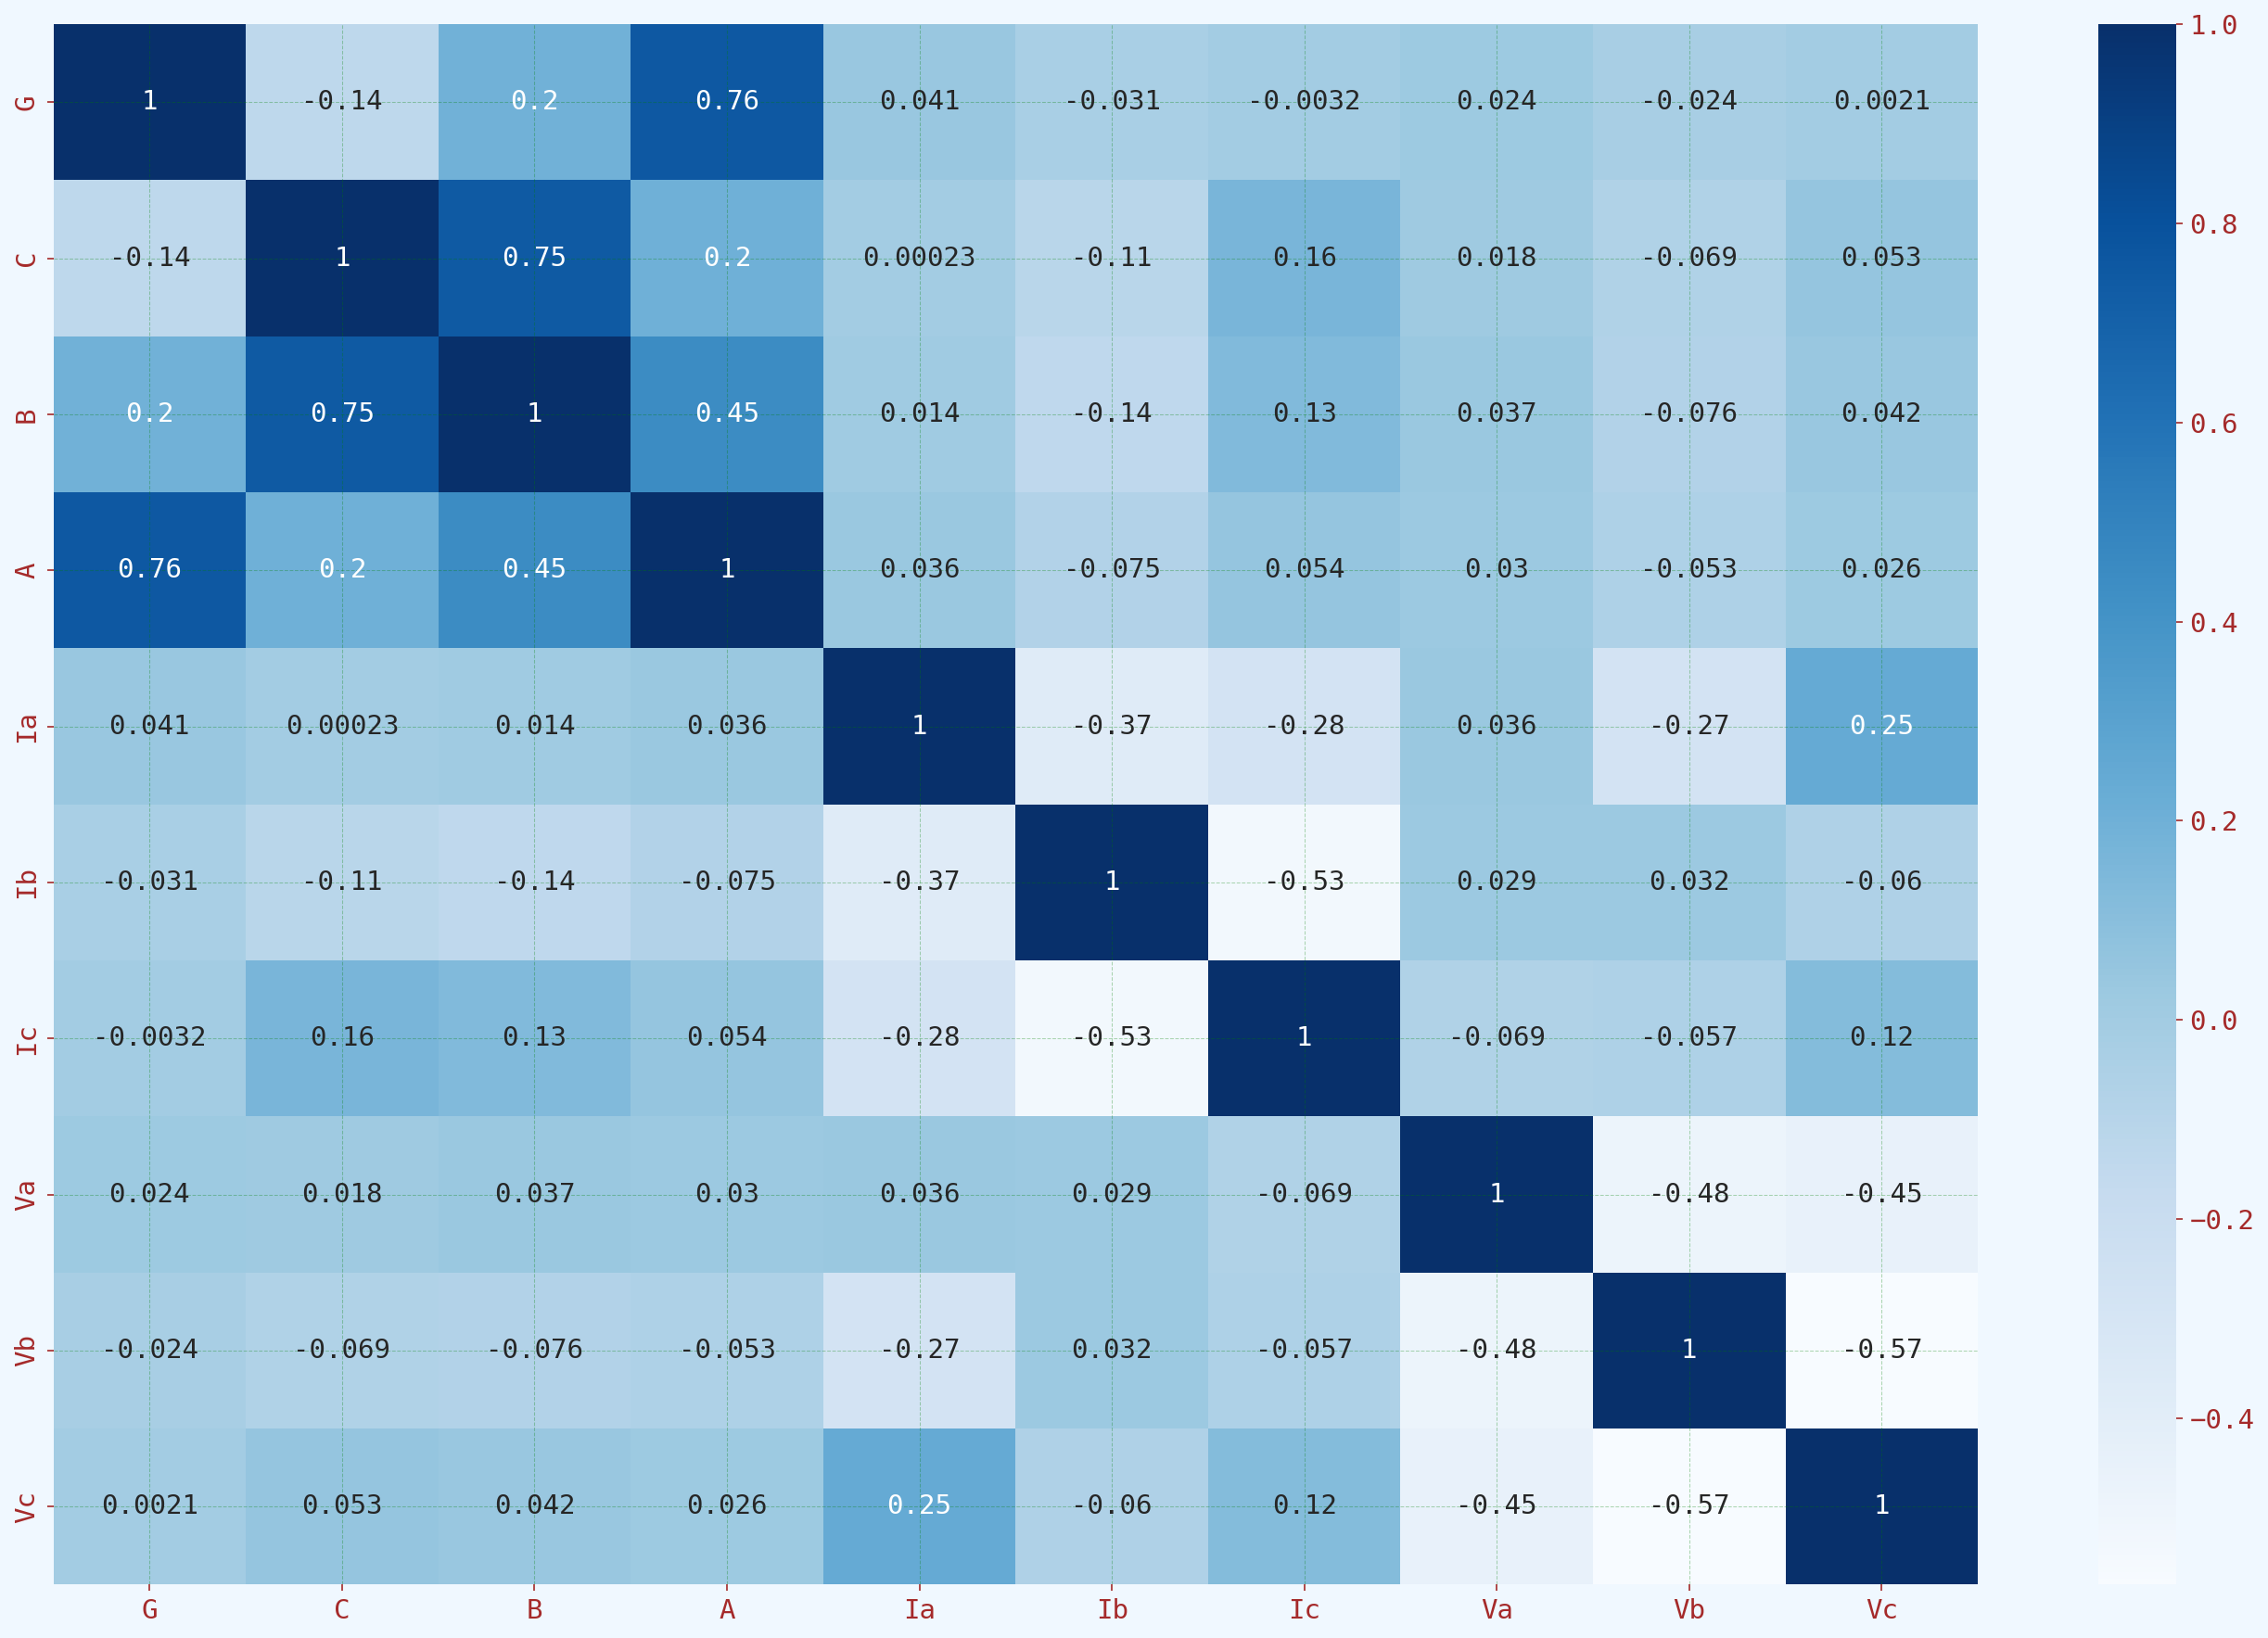

In [20]:
# Корреляционная тепловая карта
plt.figure(figsize=(18,12))
sns.heatmap(multi_data.corr(), annot=True, cmap='Blues')
plt.show()

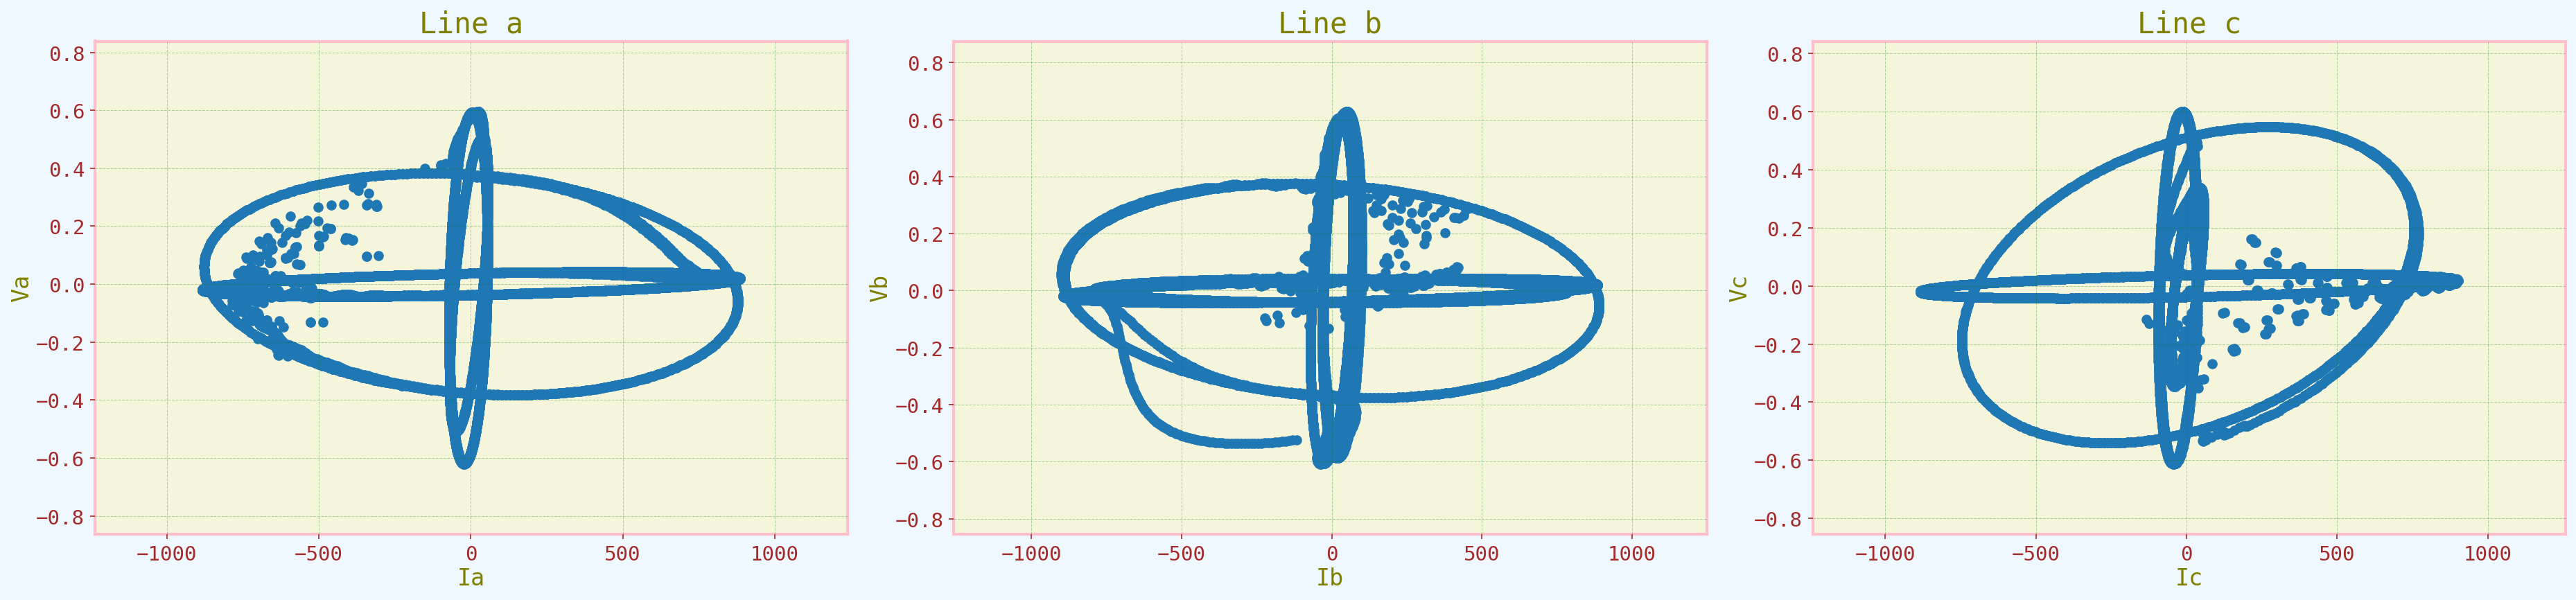

In [21]:
# Диаграмма рассеяния
plt.figure(figsize=(25,6))

a1 = plt.subplot2grid((1,3),(0,0))
a1.scatter(multi_data['Ia'], multi_data['Va'])
a1.set_title('Line a')
a1.set_xlabel('Ia')
a1.set_ylabel('Va')

a2 = plt.subplot2grid((1,3),(0,1))
a2.scatter(multi_data['Ib'], multi_data['Vb'])
a2.set_title('Line b')
a2.set_xlabel('Ib')
a2.set_ylabel('Vb')

a3 = plt.subplot2grid((1,3),(0,2))
a3.scatter(multi_data['Ic'], multi_data['Vc'])
a3.set_title('Line c')
a3.set_xlabel('Ic')
a3.set_ylabel('Vc')

plt.show()

In [22]:
# Визуализируем значения признаков
def dist(cola,colb):

    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(18,10))

    sns.distplot(multi_data[cola], label='Line Current', hist=True, color='#fc0328', ax=axs[0])
    sns.distplot(multi_data[colb], label='Line Voltage', hist=True, color='#0c06c7', ax=axs[1])

    axs[0].legend(loc='upper right', prop={'size': 12})
    axs[1].legend(loc='upper right', prop={'size': 12})

    plt.show()

<ipython-input-22-4d2e57c8beb8>:6: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


<ipython-input-22-4d2e57c8beb8>:7: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




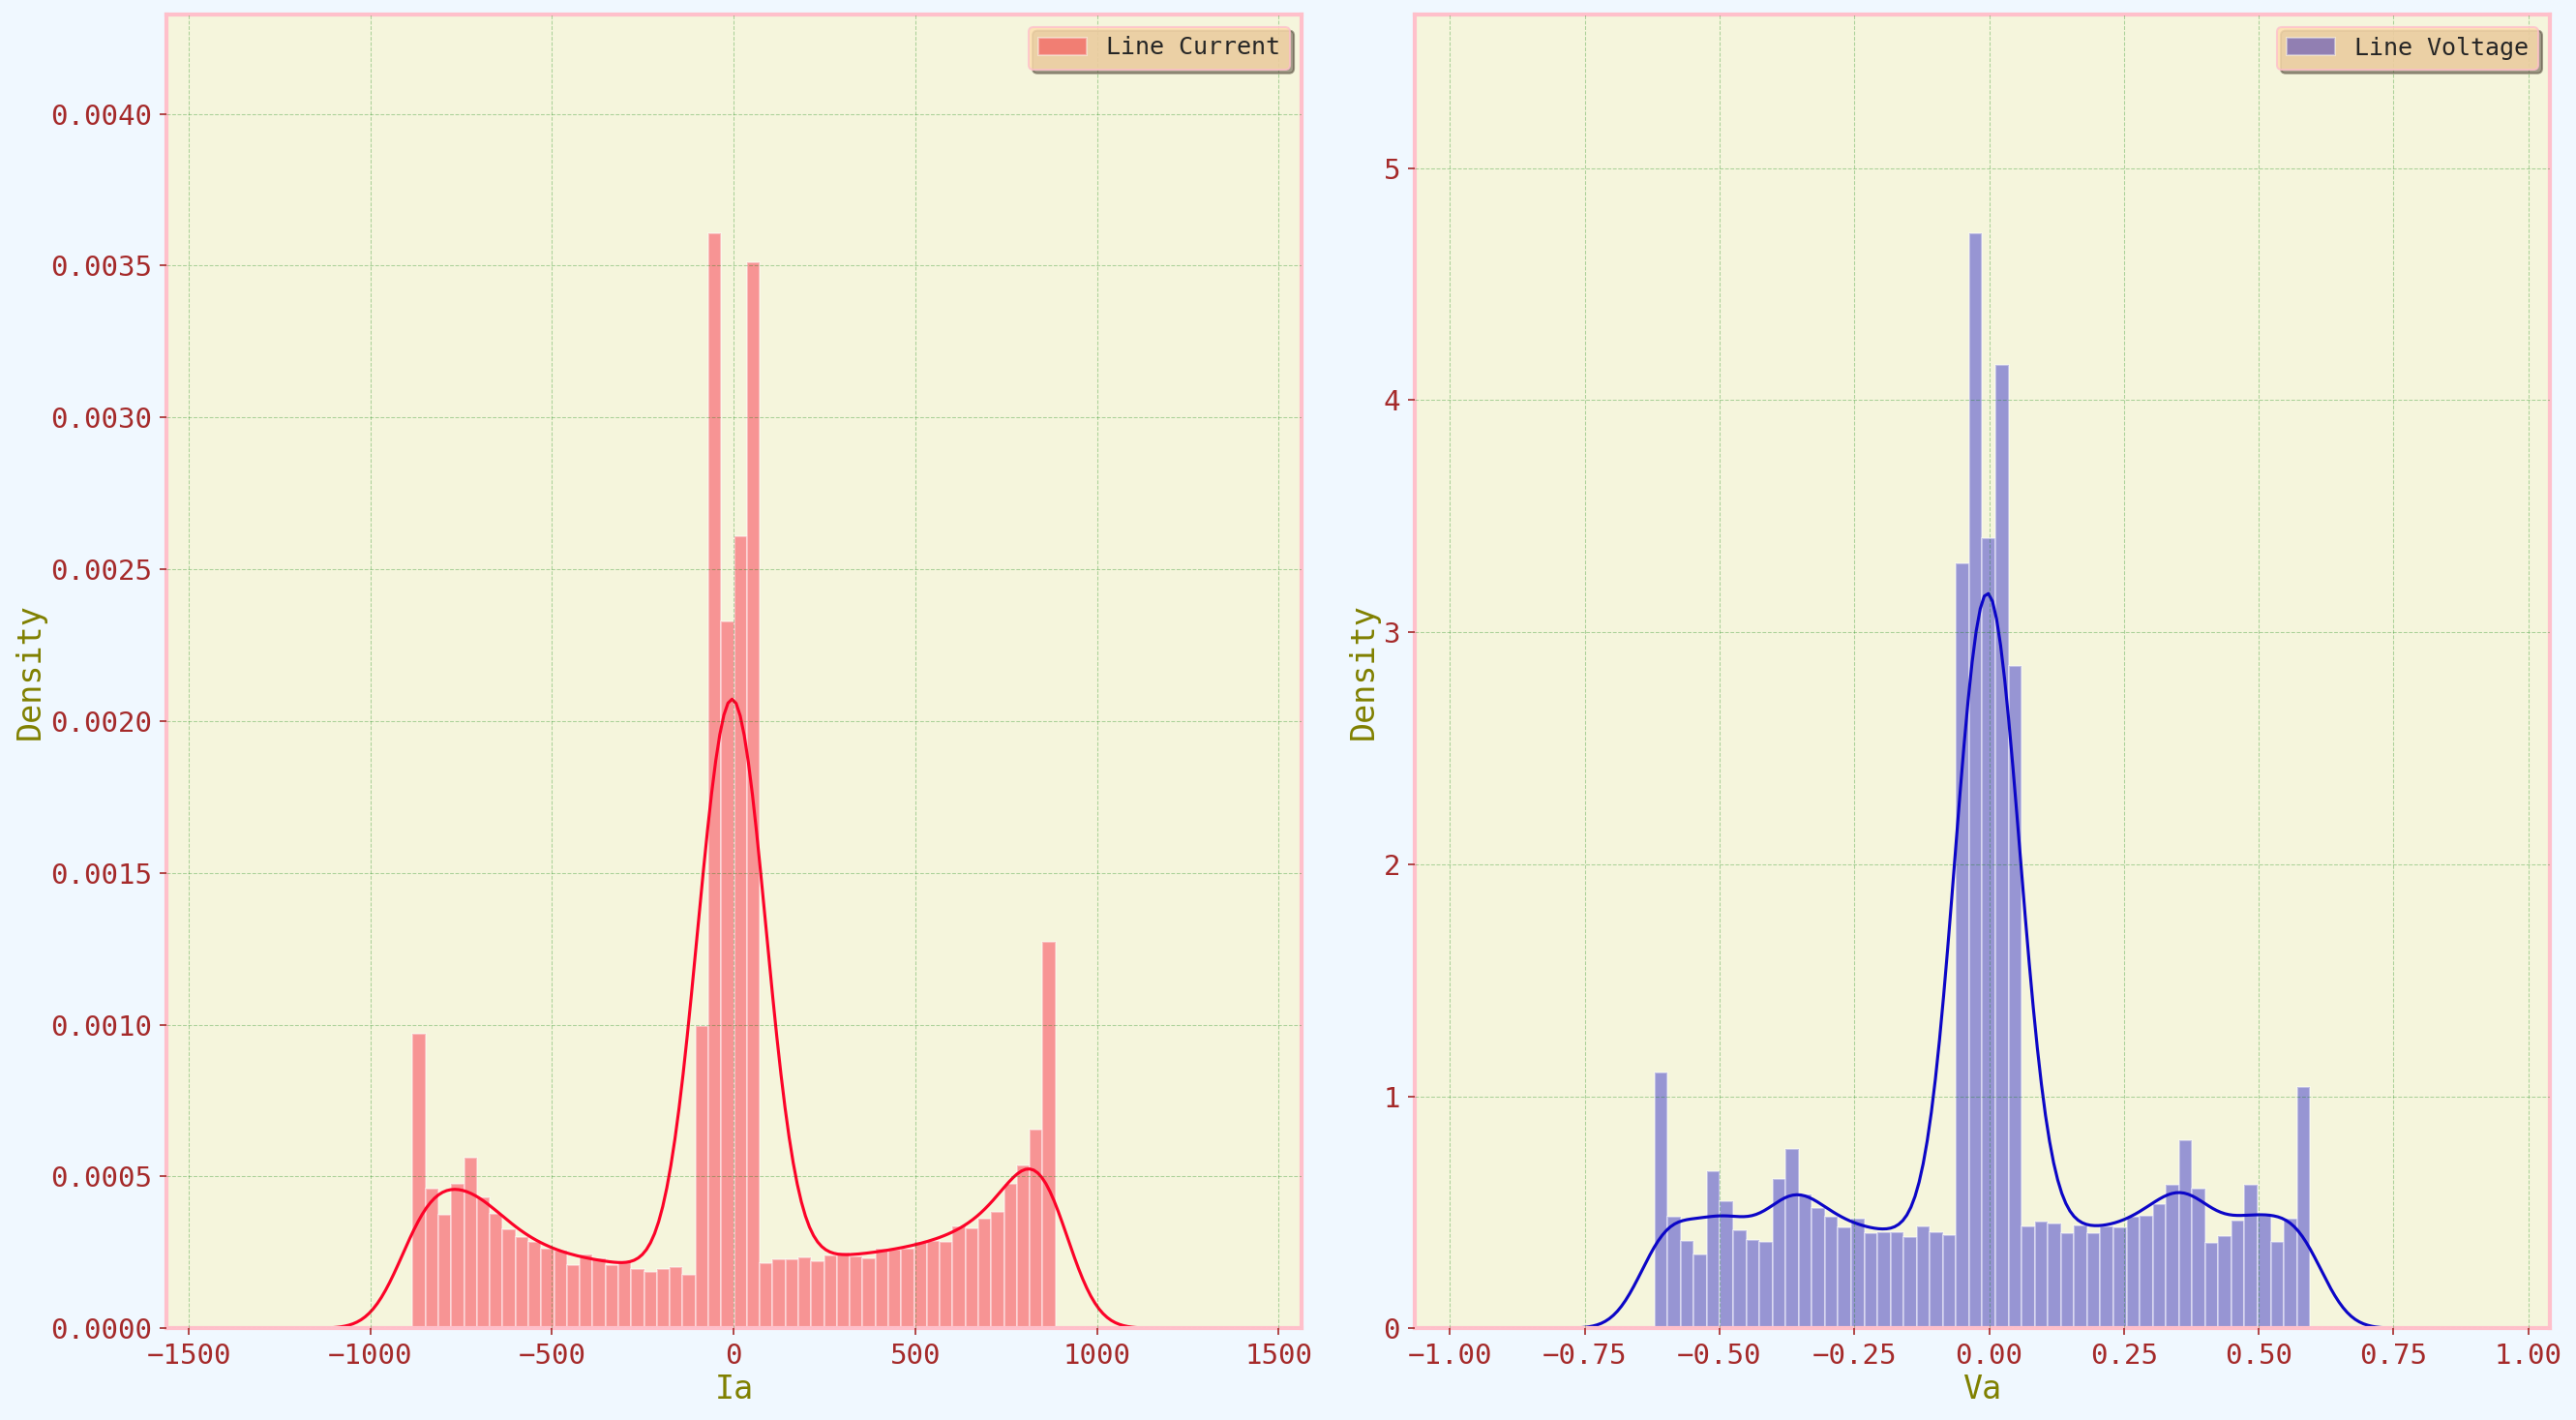

<ipython-input-22-4d2e57c8beb8>:6: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


<ipython-input-22-4d2e57c8beb8>:7: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




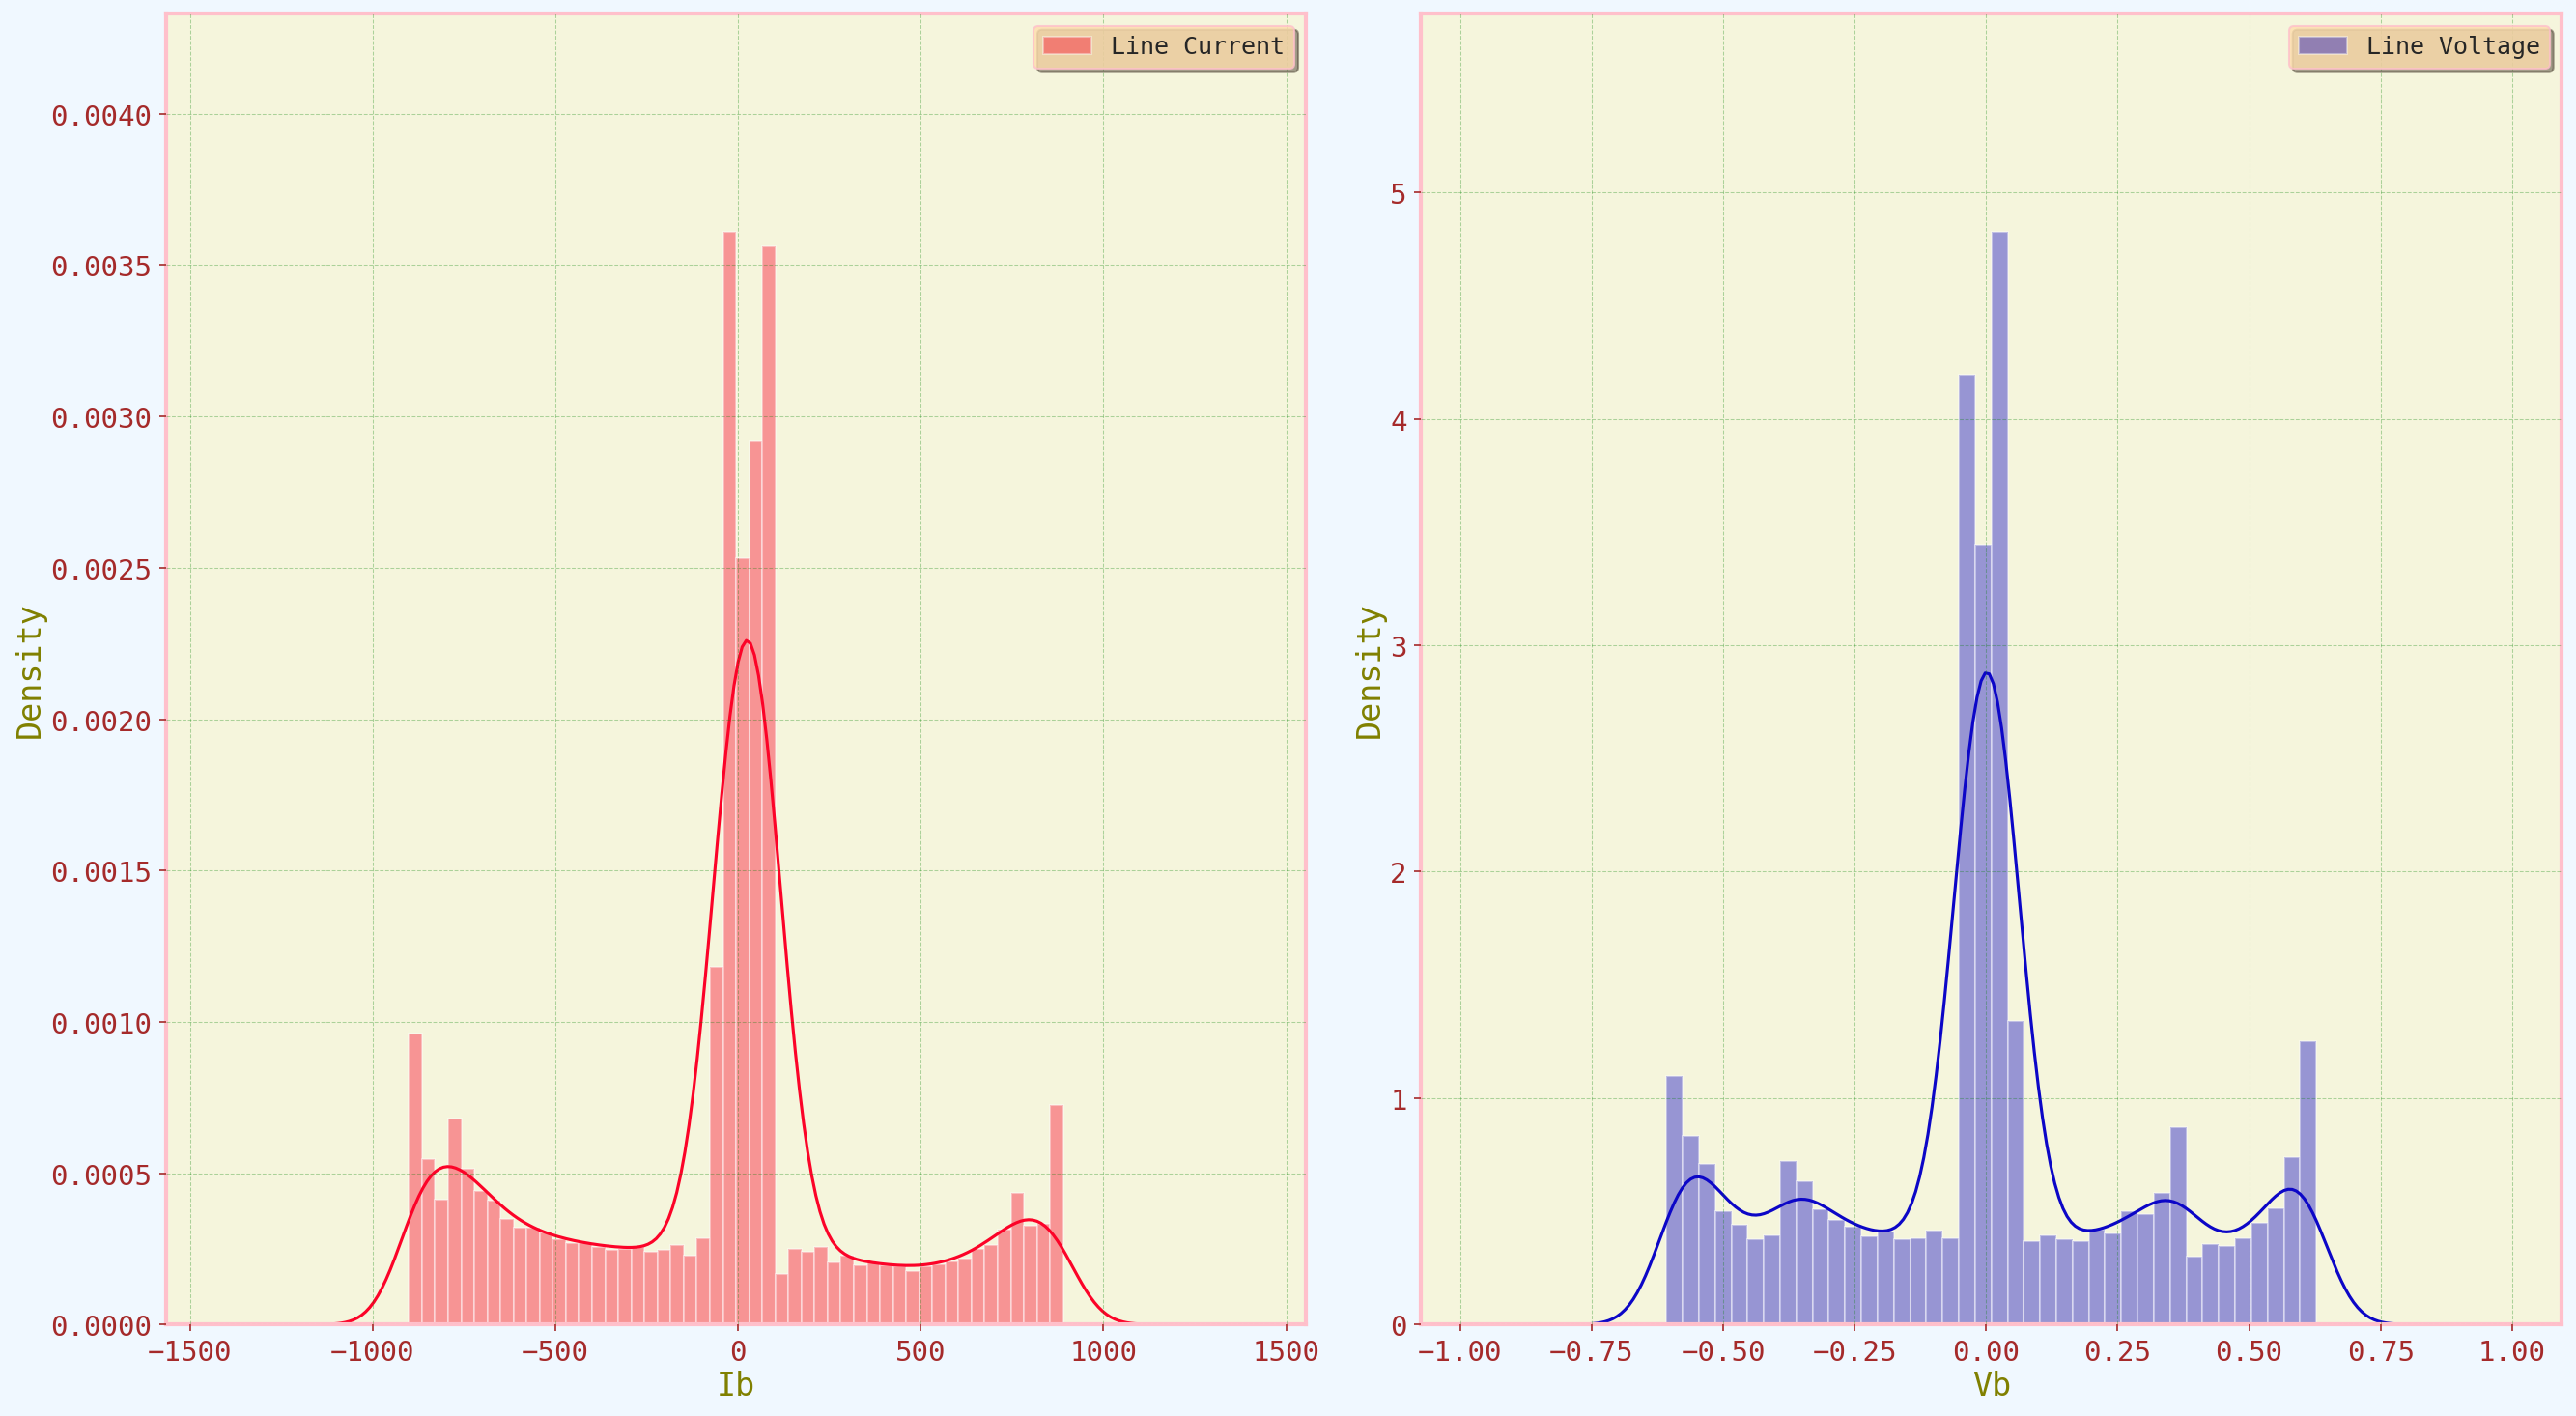

<ipython-input-22-4d2e57c8beb8>:6: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


<ipython-input-22-4d2e57c8beb8>:7: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




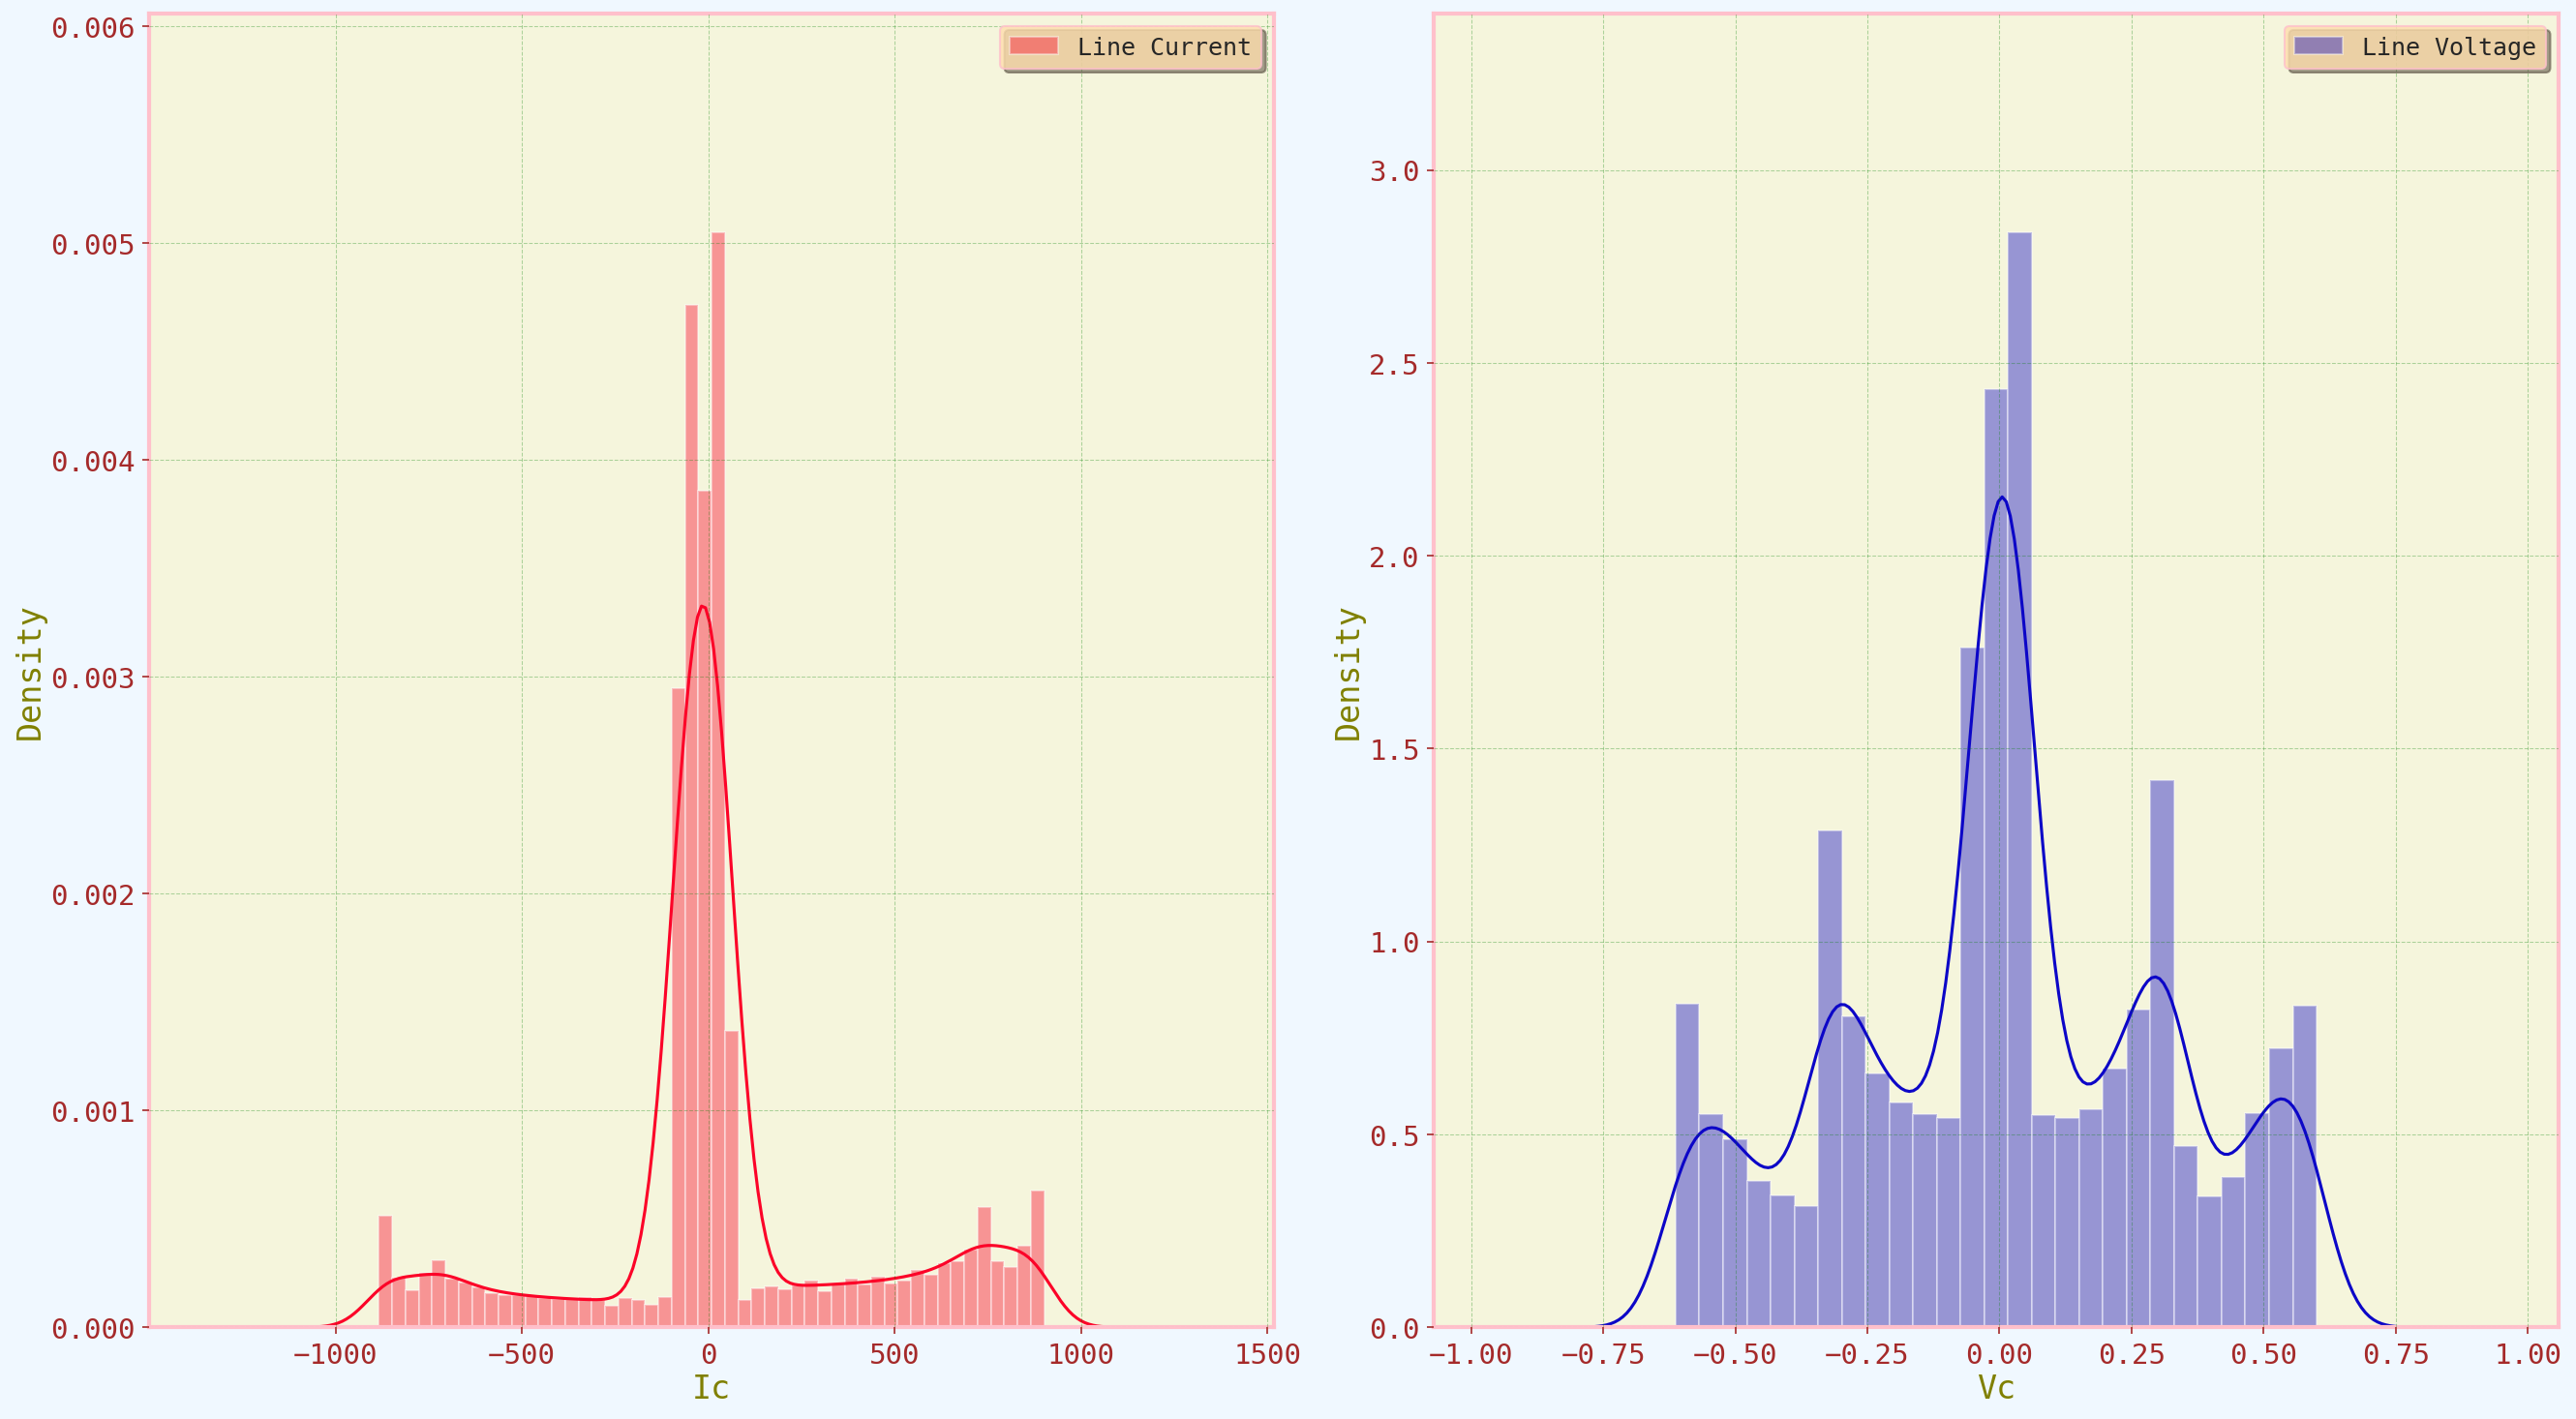

In [23]:
lines = [
    ('Ia', 'Va'),
    ('Ib', 'Vb'),
    ('Ic', 'Vc')
]

for cola,colb in lines:
    dist(cola,colb)
    print('\n')

## Шаг 3. Конструирование и выбор признаков

Поскольку выходные данные имеют четыре разных типа, мы помещаем их вместе в один столбец, и перестановки становятся разными выходными классами.

In [24]:
#Заменим названия дефектов кодами

multi_data['faultType'] = multi_data['G'].astype(str) + multi_data['C'].astype(str) + multi_data['B'].astype(str) + multi_data['A'].astype(str)
multi_data.head()

,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc,faultType
0,1,0,0,1,-151.291812,-9.677452,85.800162,0.400750,-0.132935,-0.267815,1001
1,1,0,0,1,-336.186183,-76.283262,18.328897,0.312732,-0.123633,-0.189099,1001
2,1,0,0,1,-502.891583,-174.648023,-80.924663,0.265728,-0.114301,-0.151428,1001
3,1,0,0,1,-593.941905,-217.703359,-124.891924,0.235511,-0.104940,-0.130570,1001
4,1,0,0,1,-643.663617,-224.159427,-132.282815,0.209537,-0.095554,-0.113983,1001


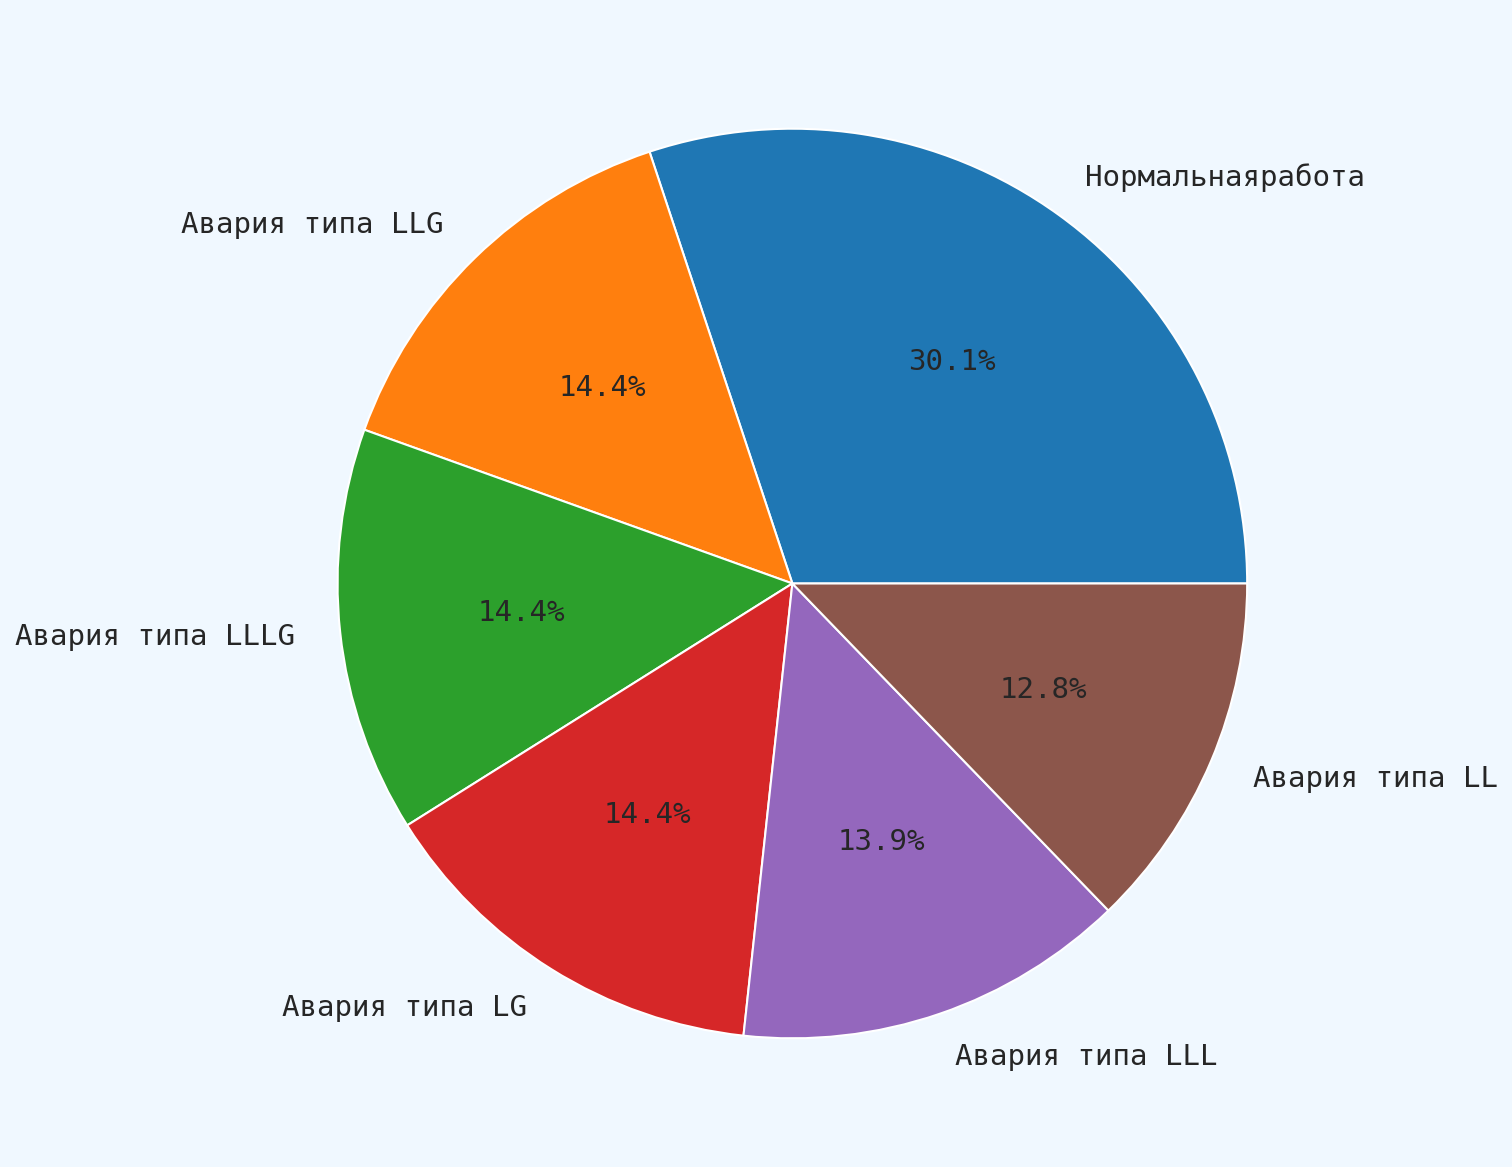

In [25]:
# Процентное соотношение количества, представленных типов проблем в данных
plt.pie(multi_data['faultType'].value_counts(), autopct='%1.1f%%',
       labels=['Нормальнаяработа', 'Авария типа LLG', 'Авария типа LLLG', 'Авария типа LG', 'Авария типа LLL', 'Авария типа LL'])
plt.show()

## Шаг 4-$a$. Построение модели — мультиклассовый классификатор

In [26]:
X = multi_data.drop(['G','C','B','A','faultType'], axis=1)
y = multi_data['faultType']

In [27]:
X

,Ia,Ib,Ic,Va,Vb,Vc
0,-151.291812,-9.677452,85.800162,0.400750,-0.132935,-0.267815
1,-336.186183,-76.283262,18.328897,0.312732,-0.123633,-0.189099
2,-502.891583,-174.648023,-80.924663,0.265728,-0.114301,-0.151428
3,-593.941905,-217.703359,-124.891924,0.235511,-0.104940,-0.130570
4,-643.663617,-224.159427,-132.282815,0.209537,-0.095554,-0.113983
...,...,...,...,...,...,...
7856,-66.237921,38.457041,24.912239,0.094421,-0.552019,0.457598
7857,-65.849493,37.465454,25.515675,0.103778,-0.555186,0.451407
7858,-65.446698,36.472055,26.106554,0.113107,-0.558211,0.445104
7859,-65.029633,35.477088,26.684731,0.122404,-0.561094,0.438690


In [28]:
y

0       1001
1       1001
2       1001
3       1001
4       1001
        ... 
7856    0000
7857    0000
7858    0000
7859    0000
7860    0000
Name: faultType, Length: 7861, dtype: object

In [29]:
# Кодировка меток в нескольких столбцах в scikit-learn
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(y)

In [30]:
y


array([3, 3, 3, ..., 0, 0, 0])

In [31]:
# Разобъем наш DF на тестовую и обучающую выборку, используем ф-цию train_test_split()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6288, 6), (1573, 6), (6288,), (1573,))

In [32]:
model_2 = RandomForestClassifier()

In [33]:
model_2.fit(X_train, y_train)
y_pred = model_2.predict(X_test)

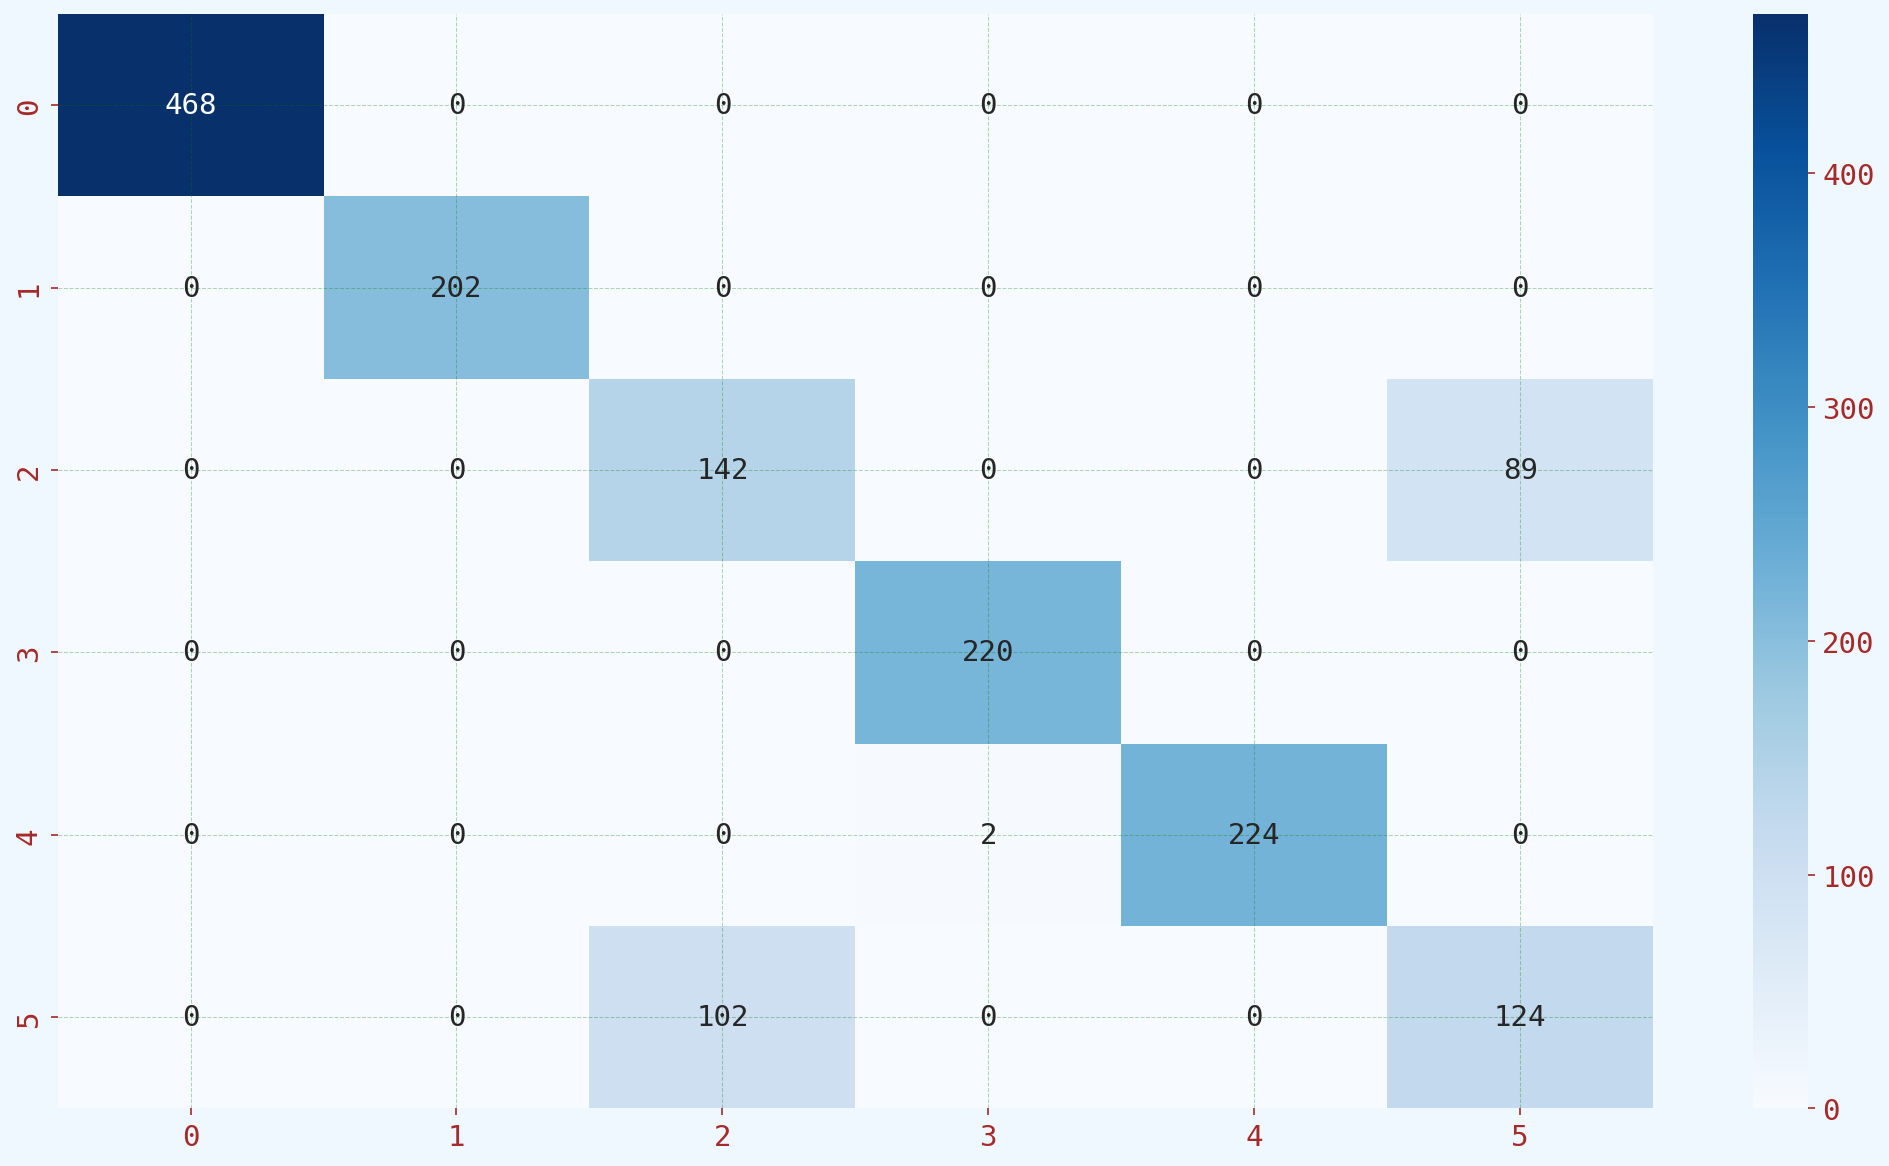

In [34]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='.4g')
plt.show()

In [35]:
print(f'Процент правильно классифицированных экземпляров: {accuracy_score(y_test, y_pred)*100:.03f}%')

Процент правильно классифицированных экземпляров: 87.730%


In [36]:
print(f"Отчет о классификации:\n{classification_report(y_test, y_pred)}")

Отчет о классификации:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       468
           1       1.00      1.00      1.00       202
           2       0.58      0.61      0.60       231
           3       0.99      1.00      1.00       220
           4       1.00      0.99      1.00       226
           5       0.58      0.55      0.56       226

    accuracy                           0.88      1573
   macro avg       0.86      0.86      0.86      1573
weighted avg       0.88      0.88      0.88      1573



## **Анализ ошибок на уровне классов**

In [37]:
cr = classification_report(y_test, y_pred, output_dict=True)
cr.keys()

dict_keys(['0', '1', '2', '3', '4', '5', 'accuracy', 'macro avg', 'weighted avg'])

Извлечем классовые $f$-меры из отчета о классификации

In [38]:
f1_scores = {}
for key, val in cr.items():
    if key == 'accuracy':
        break
    class_name = le.inverse_transform([int(key)])[0]
    f1_scores[class_name] = val["f1-score"]
sorted(f1_scores.items(), key=lambda x: x[1], reverse=True)

[('0000', 1.0),
 ('0110', 1.0),
 ('1011', 0.9955555555555555),
 ('1001', 0.995475113122172),
 ('0111', 0.5978947368421053),
 ('1111', 0.5649202733485194)]

In [39]:
f1_scores_df = pd.DataFrame({'class': f1_scores.keys(),
                             'f1': f1_scores.values()})
f1_scores_df

,class,f1
0,0000,1.000000
1,0110,1.000000
2,0111,0.597895
3,1001,0.995475
4,1011,0.995556
5,1111,0.564920


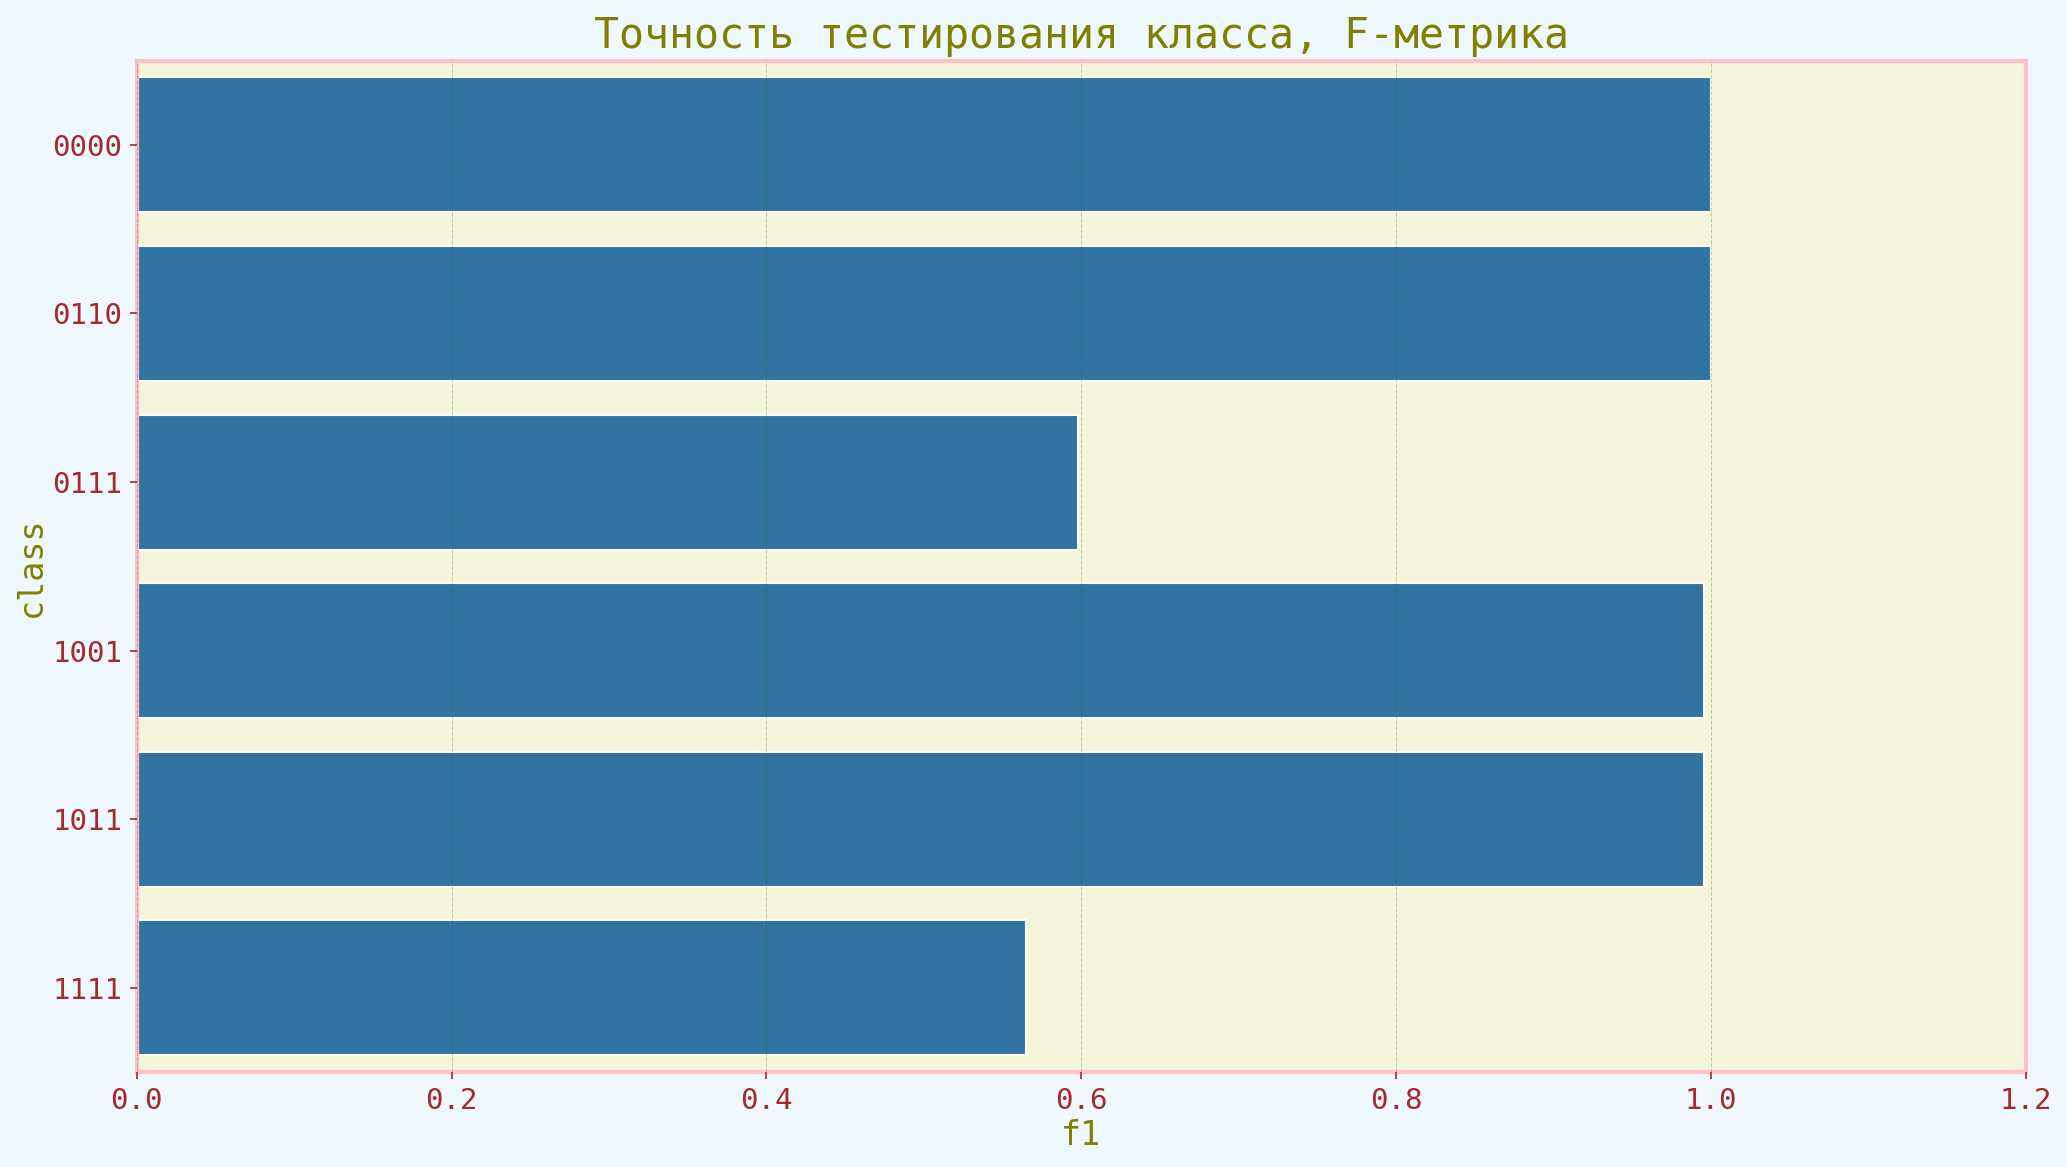

In [40]:
sns.barplot(data=f1_scores_df, x='f1', y='class')
plt.title("Точность тестирования класса, F-метрика")
plt.show()

<table width="99%"> <tr> <td bgcolor = #E6E6FA><font size=3>
<b>Выводы</b></td></tr></table>

<blockquote><ul type = "square">
<li>
Два класса показывают особенно низкое значение $f$-метрики, в то время как другие классы классифицируются очень хорошо.
</li><li>
Это классы <b>0111</b> (КЗ между всеми тремя фазами) и <b>1111</b> (симметричная КЗ между всеми тремя фазами).
<li>
Мы видим, как это может сбить с толку нашу модель.
Необходимо дополнительно проанализировать эти случаи, чтобы улучшить классификатор.

## Тестируем на реальных данных

Чтобы заполнить тестовый образец данных, посмотрим какие столбцы ждет от нас модель.

In [41]:
X_test.columns

Index(['Ia', 'Ib', 'Ic', 'Va', 'Vb', 'Vc'], dtype='object')

Для того чтобы заполнить тестовые данные, напишем небольшой сниппет на Python, который создаст заготовку, которую мы сможем заполнить.

In [42]:
{col:[0] for col in X_test.columns}

{'Ia': [0], 'Ib': [0], 'Ic': [0], 'Va': [0], 'Vb': [0], 'Vc': [0]}

In [43]:
#Выберем 3900 строку из исходного DataFrame
multi_data.iloc [[3900]]

,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc,faultType
3900,0,1,1,1,882.749138,-485.837326,-394.849943,0.017374,-0.042112,0.024738,0111


In [44]:
test_df = {'Ia': [-439], 'Ib': [11], 'Ic': [-43], 'Va': [-0.2], 'Vb': [0.52], 'Vc': [-0.3]}

In [45]:
example_df = pd.DataFrame(data=test_df, columns=X.columns)

In [46]:
example_df

,Ia,Ib,Ic,Va,Vb,Vc
0,-439,11,-43,-0.2,0.52,-0.3


Теперь этот датафрейм можно использовать для предсказаний

In [47]:
model_2.predict(example_df)

array([3])

Так же можно получить вероятность другх исходов

In [48]:
model_2.predict_proba(example_df)

array([[0., 0., 0., 1., 0., 0.]])

In [49]:
model_2.classes_

array([0, 1, 2, 3, 4, 5])

Задача модели выбрать один из заранее известных вариантов. В реальности модель распределяет вероятности между всемя существующими классами. Сумма `array([[0.01, 0.  , 0.  , 0.34, 0.65, 0.  ]])` дает единицу, то есть модель уверена на 100%, что данные относятся кодному из вариантов.

**ИТОГО:**


1.   Проанализировали данные
2.   Построили модель
3.   Научились делать с помощью нее предсказания
4.   Посмотрели на распределение вероятностей




---



---



# **Выбор модели**

## **Алгоритм "Логистическая регрессия"**

In [50]:
print(f'Процент правильно классифицированных экземпляров: {accuracy_score(y_test, y_pred)*100:.03f}%')

Процент правильно классифицированных экземпляров: 87.730%


In [51]:
print(f"Отчет о классификации:\n{classification_report(y_test, y_pred)}")

Отчет о классификации:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       468
           1       1.00      1.00      1.00       202
           2       0.58      0.61      0.60       231
           3       0.99      1.00      1.00       220
           4       1.00      0.99      1.00       226
           5       0.58      0.55      0.56       226

    accuracy                           0.88      1573
   macro avg       0.86      0.86      0.86      1573
weighted avg       0.88      0.88      0.88      1573



In [52]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_lr = logreg.predict(X_test)

log_train = round(logreg.score(X_train, y_train) * 100, 2)
log_accuracy = round(accuracy_score(y_pred_lr, y_test) * 100, 2)


print("Training Accuracy    :",log_train ,"%")
print("Model Accuracy Score :",log_accuracy ,"%")
print("\033[1m--------------------------------------------------------\033[0m")
print("Classification_Report: \n",classification_report(y_test,y_pred_lr))
print("\033[1m--------------------------------------------------------\033[0m")


Training Accuracy    : 32.38 %
Model Accuracy Score : 31.91 %
--------------------------------------------------------
Classification_Report: 
               precision    recall  f1-score   support

           0       0.32      1.00      0.48       468
           1       0.00      0.00      0.00       202
           2       0.67      0.01      0.02       231
           3       0.00      0.00      0.00       220
           4       0.00      0.00      0.00       226
           5       0.32      0.14      0.20       226

    accuracy                           0.32      1573
   macro avg       0.22      0.19      0.12      1573
weighted avg       0.24      0.32      0.17      1573

--------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-p

## **Алгоритм "Дерево решений" (Decision Tree Classifier)**

In [53]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
%matplotlib inline

decision = DecisionTreeClassifier()
decision.fit(X_train, y_train)
y_pred_dec = decision.predict(X_test)

decision_train = round(decision.score(X_train, y_train) * 100, 2)
decision_accuracy = round(accuracy_score(y_pred_dec, y_test) * 100, 2)

print("Training Accuracy    :",decision_train ,"%")
print("Model Accuracy Score :",decision_accuracy ,"%")
print("\033[1m--------------------------------------------------------\033[0m")
print("Classification_Report: \n",classification_report(y_test,y_pred_dec))
print("\033[1m--------------------------------------------------------\033[0m")


Training Accuracy    : 100.0 %
Model Accuracy Score : 88.37 %
--------------------------------------------------------
Classification_Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       468
           1       1.00      1.00      1.00       202
           2       0.61      0.63      0.62       231
           3       0.99      1.00      1.00       220
           4       1.00      0.99      1.00       226
           5       0.61      0.58      0.59       226

    accuracy                           0.88      1573
   macro avg       0.87      0.87      0.87      1573
weighted avg       0.88      0.88      0.88      1573

--------------------------------------------------------


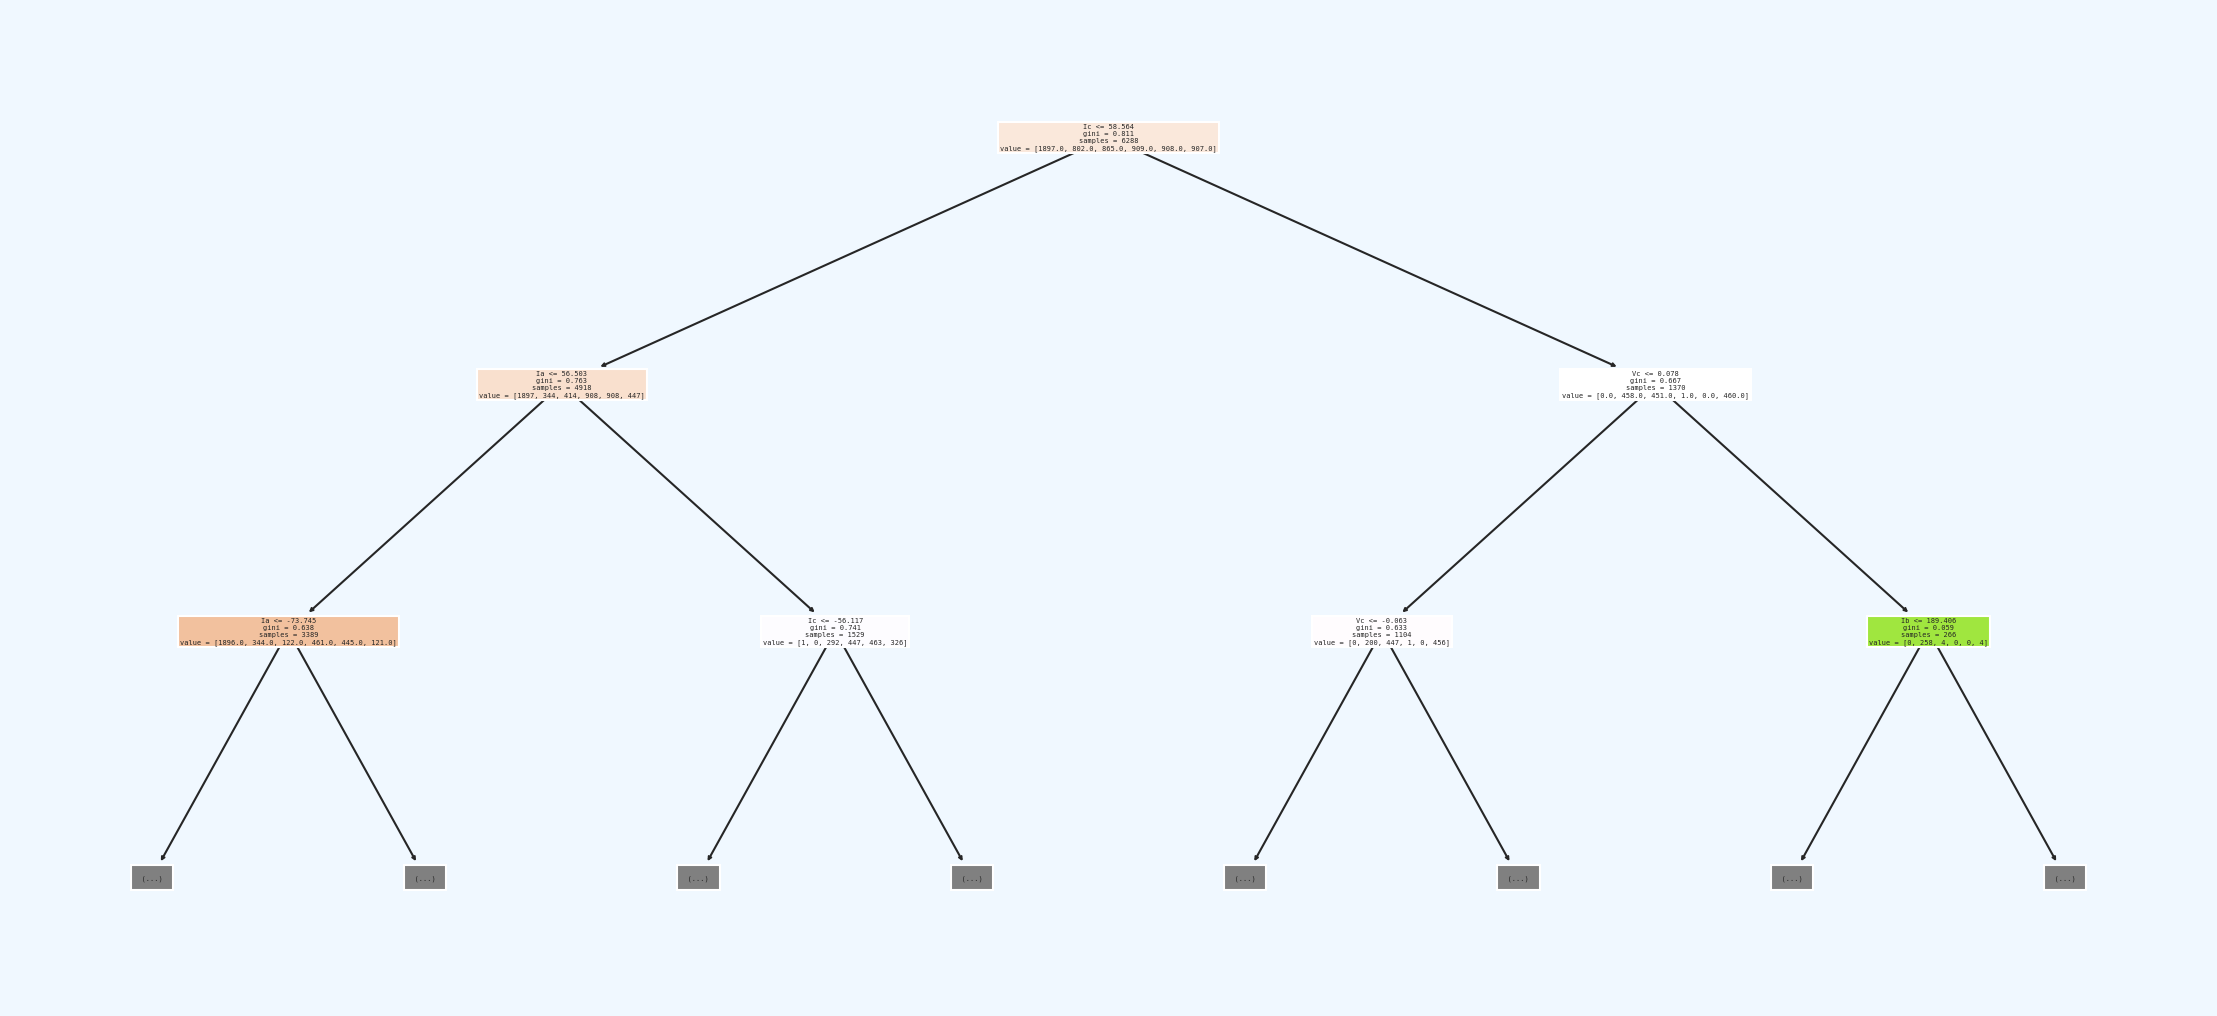

In [54]:
from sklearn.tree import plot_tree

plt.figure(figsize=(15,7))
plot_tree(decision, filled=True, max_depth=2, feature_names=['Ia', 'Ib', 'Ic', 'Va', 'Vb', 'Vc'])
plt.show()

In [55]:
from sklearn import tree
def tree_plot(model_name):
    plt.figure(figsize=(20,20))
    features = multi_data.columns
    classes = ['NO Fault','Line A to Ground Fault','Line B to Line C Fault','Line A Line B to Ground Fault','Line A Line B Line C','Line A Line B Line C to Ground Fault']
    tree.plot_tree(model_name, feature_names=features, class_names=classes, filled=True)
    plt.show()

[Text(0.5835476850019786, 0.9967741935483871, 'x[2] <= 58.564\ngini = 0.811\nsamples = 6288\nvalue = [1897.0, 802.0, 865.0, 909.0, 908.0, 907.0]'),
 Text(0.3171745152354571, 0.9903225806451613, 'x[0] <= 56.503\ngini = 0.763\nsamples = 4918\nvalue = [1897, 344, 414, 908, 908, 447]'),
 Text(0.16106054610209736, 0.9838709677419355, 'x[0] <= -73.745\ngini = 0.638\nsamples = 3389\nvalue = [1896.0, 344.0, 122.0, 461.0, 445.0, 121.0]'),
 Text(0.07993668381480015, 0.9774193548387097, 'x[1] <= 43.497\ngini = 0.662\nsamples = 1035\nvalue = [0, 0, 106, 420, 404, 105]'),
 Text(0.02849228333992877, 0.9709677419354839, 'x[1] <= -98.753\ngini = 0.404\nsamples = 584\nvalue = [0, 0, 0, 420, 164, 0]'),
 Text(0.012663237039968342, 0.964516129032258, 'x[3] <= 0.059\ngini = 0.103\nsamples = 147\nvalue = [0, 0, 0, 8, 139, 0]'),
 Text(0.006331618519984171, 0.9580645161290322, 'gini = 0.0\nsamples = 139\nvalue = [0, 0, 0, 0, 139, 0]'),
 Text(0.018994855559952513, 0.9580645161290322, 'gini = 0.0\nsamples = 8\n

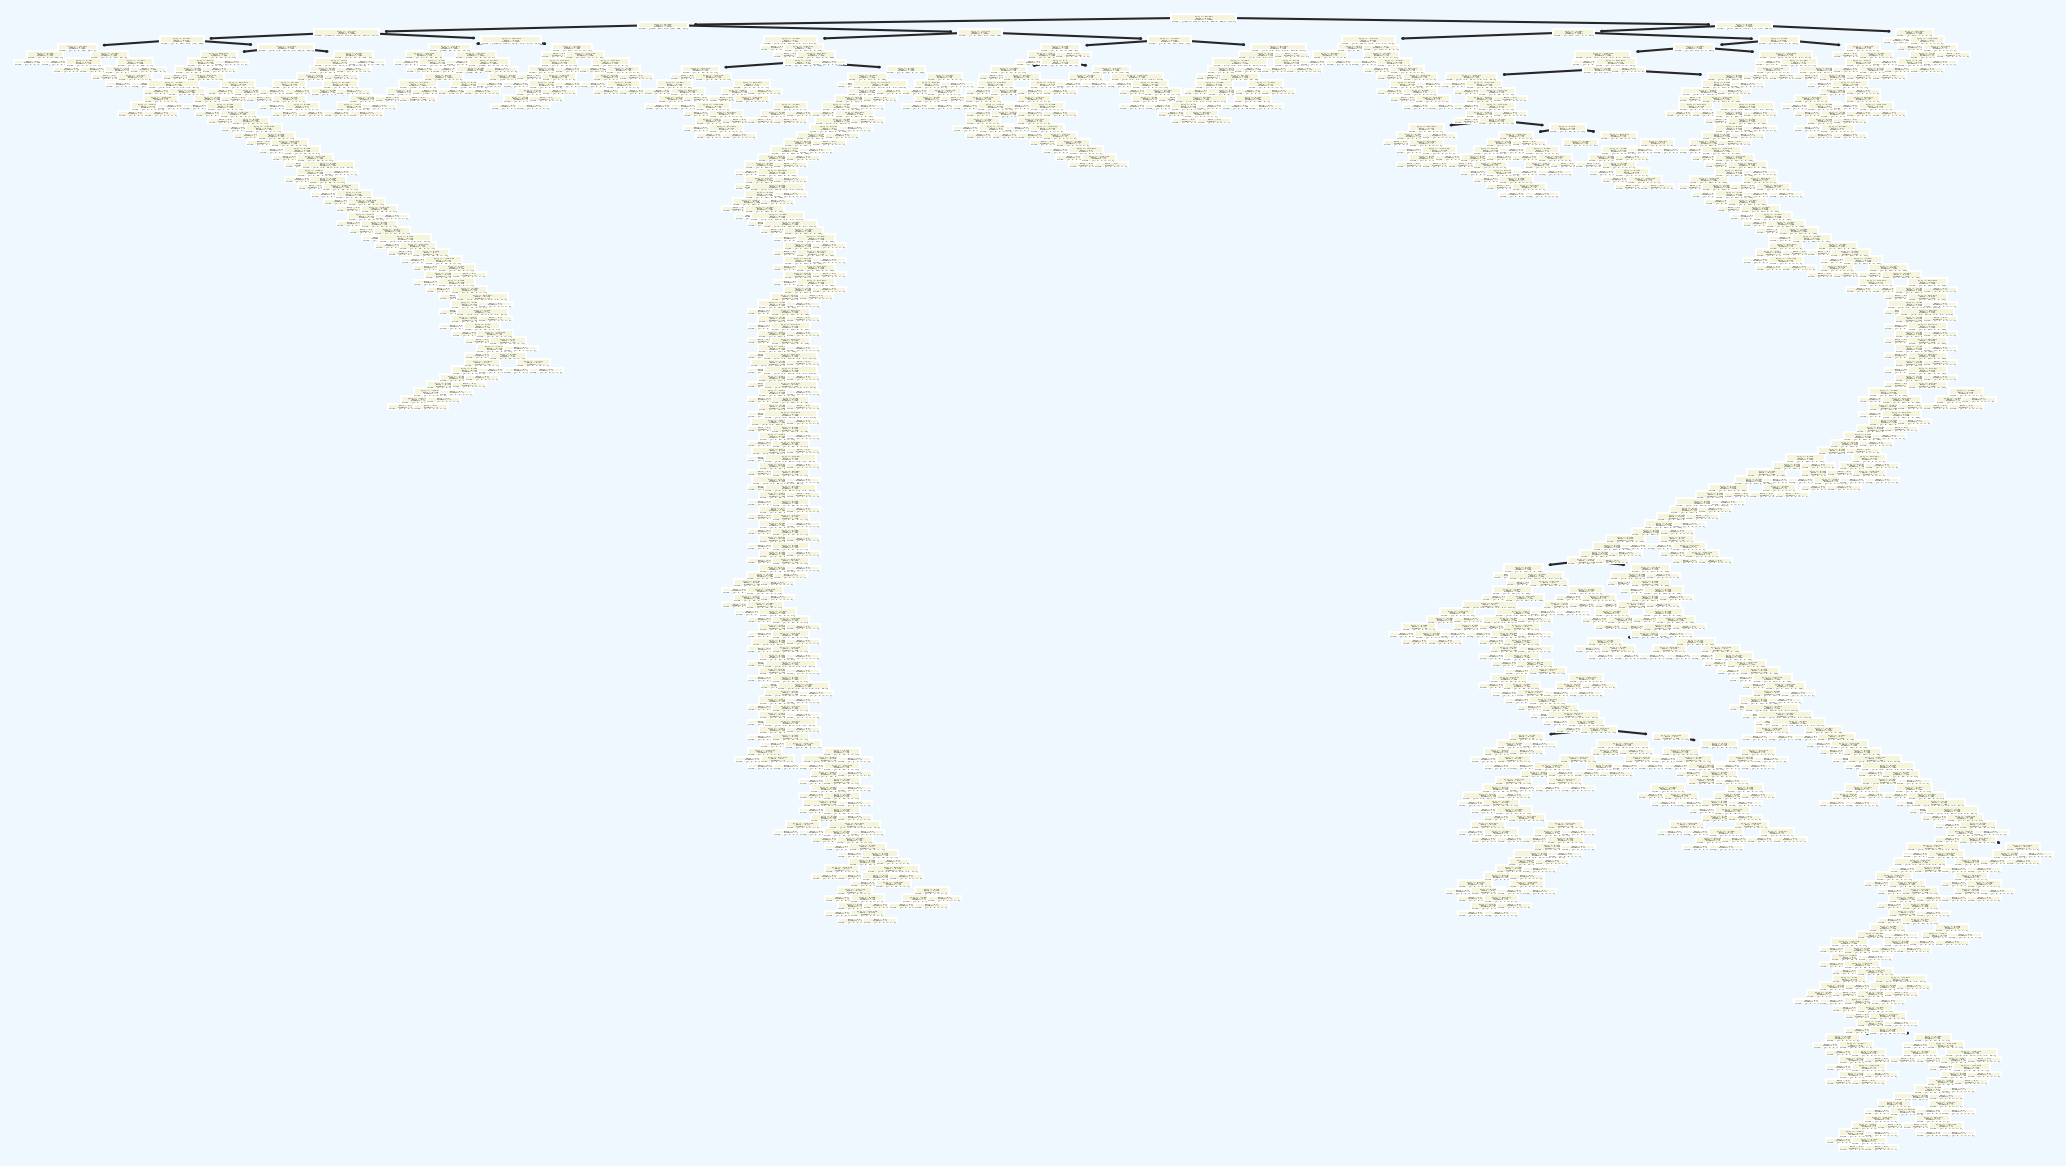

In [56]:
tree.plot_tree(decision)

## **Алгоритм "Случайный лес" (Random Forest Classifier)**

In [57]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)
y_pred_rf = random_forest.predict(X_test)
random_forest.score(X_train, y_train)

random_forest_train = round(random_forest.score(X_train, y_train) * 100, 2)
random_forest_accuracy = round(accuracy_score(y_pred_rf, y_test) * 100, 2)

print("Training Accuracy    :",random_forest_train ,"%")
print("Model Accuracy Score :",random_forest_accuracy ,"%")
print("\033[1m--------------------------------------------------------\033[0m")
print("Classification_Report: \n",classification_report(y_test,y_pred_rf))
print("\033[1m--------------------------------------------------------\033[0m")


Training Accuracy    : 100.0 %
Model Accuracy Score : 88.05 %
--------------------------------------------------------
Classification_Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       468
           1       1.00      1.00      1.00       202
           2       0.60      0.60      0.60       231
           3       0.99      1.00      1.00       220
           4       1.00      0.99      1.00       226
           5       0.59      0.58      0.59       226

    accuracy                           0.88      1573
   macro avg       0.86      0.86      0.86      1573
weighted avg       0.88      0.88      0.88      1573

--------------------------------------------------------


## **Алгоритм "Xgboost" (XGB Classifier)**

In [58]:
import xgboost as Xgb
xgb = Xgb.XGBClassifier()
xgb.fit(X_train,y_train)
y_pred_xgb = xgb.predict(X_test)
xgb.score(X_train, y_train)

xgb_train = round(xgb.score(X_train, y_train) * 100, 2)
xgb_accuracy = round(accuracy_score(y_pred_xgb, y_test) * 100, 2)

print("Training Accuracy    :",xgb_train ,"%")
print("Model Accuracy Score :",xgb_accuracy ,"%")
print("\033[1m--------------------------------------------------------\033[0m")
print("Classification_Report: \n",classification_report(y_test,y_pred_xgb))
print("\033[1m--------------------------------------------------------\033[0m")

Training Accuracy    : 93.27 %
Model Accuracy Score : 81.44 %
--------------------------------------------------------
Classification_Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       468
           1       1.00      1.00      1.00       202
           2       0.37      0.35      0.36       231
           3       0.99      1.00      1.00       220
           4       1.00      0.99      1.00       226
           5       0.36      0.38      0.37       226

    accuracy                           0.81      1573
   macro avg       0.79      0.79      0.79      1573
weighted avg       0.81      0.81      0.81      1573

--------------------------------------------------------


## **Алгоритм "Метод опорных векторов" (Support Vector Machines)**

In [59]:
# Support Vector Machines
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)

svc_train = round(svc.score(X_train, y_train) * 100, 2)
svc_accuracy = round(accuracy_score(y_pred_svc, y_test) * 100, 2)

print("Training Accuracy    :",svc_train ,"%")
print("Model Accuracy Score :",svc_accuracy ,"%")
print("\033[1m--------------------------------------------------------\033[0m")
print("Classification_Report: \n",classification_report(y_test,y_pred_svc))
print("\033[1m--------------------------------------------------------\033[0m")

Training Accuracy    : 76.21 %
Model Accuracy Score : 74.32 %
--------------------------------------------------------
Classification_Report: 
               precision    recall  f1-score   support

           0       0.89      1.00      0.94       468
           1       0.77      0.87      0.82       202
           2       0.48      0.23      0.31       231
           3       0.78      0.89      0.83       220
           4       0.73      0.79      0.76       226
           5       0.46      0.44      0.45       226

    accuracy                           0.74      1573
   macro avg       0.68      0.70      0.68      1573
weighted avg       0.71      0.74      0.72      1573

--------------------------------------------------------


## **Сравнение различных моделей**

In [60]:
models = pd.DataFrame({
    'Модель': [
        'Методы опорных векторов (Support Vector Machines)', 'Логистическая регрессия (Logistic Regression)', 'Случайный лес (Random Forest)',
        'Древо решени (Decision Tree)', 'XGBКлассификатор (XGBClassifier)'
    ],

    'Точность обучения':
    [log_train, svc_train, decision_train, random_forest_train, xgb_train],

    'Оценка точности модели': [
        log_accuracy, svc_accuracy, decision_accuracy, random_forest_accuracy,
        xgb_accuracy
    ]
})

In [61]:
pd.set_option('display.precision', 2)
models.sort_values(by='Оценка точности модели', ascending=False).style.background_gradient(
        cmap='coolwarm').hide_index().set_properties(**{
            'font-family': 'Arial',
            'color': 'LigntGreen',
            'font-size': '15px'
        })

<ipython-input-61-4ec0d594ceda>:3: FutureWarning:

this method is deprecated in favour of `Styler.hide(axis="index")`



Модель,Точность обучения,Оценка точности модели
Случайный лес (Random Forest),100.000000,88.370000
Древо решени (Decision Tree),100.000000,88.050000
XGBКлассификатор (XGBClassifier),93.270000,81.440000
Логистическая регрессия (Logistic Regression),76.210000,74.320000
Методы опорных векторов (Support Vector Machines),32.380000,31.910000




## **Предсказание результатов**

### **1. Random Forest Classifier**

In [62]:
prediction1 = random_forest.predict(X_test)
print(prediction1)

[3 1 0 ... 1 0 0]


In [63]:
cross_checking = pd.DataFrame({'Фактический' : y_test , 'Предсказанный' : prediction1})
cross_checking.sample(5).style.background_gradient(
        cmap='coolwarm').set_properties(**{
            'font-family': 'Arial',
            'color': 'White',
            'font-size': '15px'
        })

,Фактический,Предсказанный
470,0,0
6,3,3
528,4,4
713,0,0
1377,4,4


### **2. Decision Tree Classifier**

In [64]:
prediction2 = decision.predict(X_test)
print(prediction2)

[3 1 0 ... 1 0 0]


In [65]:
cross_checking = pd.DataFrame({'Фактический' : y_test , 'Предсказанный' : prediction2})
cross_checking.sample(5).style.background_gradient(
        cmap='bone').set_properties(**{
            'font-family': 'Arial',
            'color': 'LigntGreen',
            'font-size': '15px'
        })

,Фактический,Предсказанный
229,1,1
239,3,3
896,2,2
149,1,1
1473,1,1


### **3. XGB Classifier**

In [66]:
prediction3 = xgb.predict(X_test)
print(prediction3)

[3 1 0 ... 1 0 0]


In [67]:
cross_checking = pd.DataFrame({'Фактический' : y_test , 'Предсказанный' : prediction3})
cross_checking.sample(5).style.background_gradient(
        cmap='cool').set_properties(**{
            'font-family': 'Arial',
            'color': 'LigntGreen',
            'font-size': '15px'
        })

,Фактический,Предсказанный
1430,0,0
1143,2,2
737,5,2
643,5,5
1571,0,0


### **4. Support Vector Machines**

In [68]:
prediction4 = svc.predict(X_test)
print(prediction4)

[3 1 0 ... 1 0 0]


In [69]:
cross_checking = pd.DataFrame({'Фактический' : y_test , 'Предсказанный' : prediction4})
cross_checking.sample(5).style.background_gradient(
        cmap='coolwarm').set_properties(**{
            'font-family': 'Arial',
            'color': 'LigntGreen',
            'font-size': '15px'
        })

,Фактический,Предсказанный
1524,0,0
835,5,4
989,0,0
493,1,1
162,0,0


### **5. Logistic Regression**

In [70]:
prediction5 = logreg.predict(X_test)
print(prediction5)

[0 0 0 ... 0 0 0]


In [71]:
cross_checking = pd.DataFrame({'Фактический' : y_test , 'Предсказанный' : prediction5})
cross_checking.sample(5).style.background_gradient(
        cmap='coolwarm').set_properties(**{
            'font-family': 'Arial',
            'color': 'LigntGreen',
            'font-size': '15px'
        })

,Фактический,Предсказанный
1293,2,5
566,0,0
383,4,0
1535,0,0
1442,2,5


In [72]:
#@title Результат { display-mode: "form" }

# This code will be hidden when the notebook is loaded.
%%html
<div style="color:white;
       display:fill;
       border-radius:5px;
       background-color:#637BBF;
       font-size:120%;
       font-family:Gotham;
       style:justify;
       font-family:'Gotham';
       letter-spacing:0.5px">
    <p style="padding: 10px;
          color:White;">
         Случайный лес, классификатор дерева решений, классификатор XGB дают наилучший результат и с 90-процентной точностью обнаруживают неисправности, в других моделях есть экземпляры данных, когда действительно есть неисправность, но модель не может ее идентифицировать. Логистическая регрессия дает наихудшую точность.
    </p>
</div>

## **ДОПОЛНЕНИЯ**


## **Построение более сложной модели**

1. Предварительная обработка данных с использованием StandardScaler в конвейере.
Определение и обучение простой модели нейронной сети с использованием TensorFlow и Keras.


2. Оценка нейросетевой модели на тестовых данных.


3. Определение и обучение модели случайного леса с использованием того же конвейера и GridSearchCV. GridSearchCV находит наилучшие параметры, путем обычного перебора: он создает модель для каждой возможной комбинации параметров.


4. Оценка лучшей модели Random Forest на тестовых данных.

In [78]:
# Encoding fault types
multi_data['faultType'] = multi_data['G'].astype(str) + multi_data['C'].astype(str) + multi_data['B'].astype(str) + multi_data['A'].astype(str)

# Split features and target
X = multi_data.drop(['G','C','B','A','faultType'], axis=1)
y = multi_data['faultType']

# Encode target labels
le = LabelEncoder()
y = le.fit_transform(y)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

# Define preprocessing pipeline
preprocessing_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

# Preprocess data
X_train_scaled = preprocessing_pipeline.fit_transform(X_train)
X_test_scaled = preprocessing_pipeline.transform(X_test)

# Define neural network model
def create_nn_model(input_shape, num_classes):
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=(input_shape,)),
        layers.Dense(32, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Create neural network model
input_shape = X_train_scaled.shape[1]
num_classes = len(np.unique(y_train))
nn_model = create_nn_model(input_shape, num_classes)

# Train neural network model
history = nn_model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.1)

# Evaluate neural network model
nn_test_loss, nn_test_accuracy = nn_model.evaluate(X_test_scaled, y_test)
print("Neural Network Test Accuracy:", nn_test_accuracy)

# Define Random Forest pipeline
rf_pipeline = Pipeline([
    ('clf', RandomForestClassifier())
])

# Define parameters for Random Forest GridSearchCV
rf_parameters = {
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4]
}

# Perform Random Forest GridSearchCV
rf_grid_search = GridSearchCV(rf_pipeline, rf_parameters, cv=5, n_jobs=-1, verbose=1)
rf_grid_search.fit(X_train, y_train)

# Best Random Forest model
best_rf_model = rf_grid_search.best_estimator_

# Evaluate best Random Forest model
rf_test_accuracy = best_rf_model.score(X_test, y_test)
print("Random Forest Test Accuracy:", rf_test_accuracy)


Epoch 1/50
177/177 [==============================] - 1s 3ms/step - loss: 1.2767 - accuracy: 0.5133 - val_loss: 0.8475 - val_accuracy: 0.6757
Epoch 2/50
177/177 [==============================] - 0s 2ms/step - loss: 0.6640 - accuracy: 0.7358 - val_loss: 0.5235 - val_accuracy: 0.8124
Epoch 3/50
177/177 [==============================] - 0s 2ms/step - loss: 0.4755 - accuracy: 0.7950 - val_loss: 0.4214 - val_accuracy: 0.8156
Epoch 4/50
177/177 [==============================] - 0s 2ms/step - loss: 0.4007 - accuracy: 0.8192 - val_loss: 0.3720 - val_accuracy: 0.8156
Epoch 5/50
177/177 [==============================] - 0s 2ms/step - loss: 0.3618 - accuracy: 0.8319 - val_loss: 0.3464 - val_accuracy: 0.8124
Epoch 6/50
177/177 [==============================] - 0s 2ms/step - loss: 0.3379 - accuracy: 0.8309 - val_loss: 0.3239 - val_accuracy: 0.8219
Epoch 7/50
177/177 [==============================] - 0s 2ms/step - loss: 0.3209 - accuracy: 0.8358 - val_loss: 0.3118 - val_accuracy: 0.8442
Epoch 

# Random Forest + GridSearchCV  Test Accuracy: 0.8779402415766052




попыиаемся улучшить результат

1. Увеличила количество нейронов в скрытых слоях (128, 64 и 32 нейрона 1.соответственно).

2. Добавлены слои исключения с коэффициентом исключения 0,5 после каждого  слоя, чтобы предотвратить переобучение.


3. Модель обучалась в течение 100 эпох, чтобы увеличить время обучения.


In [79]:
# Encoding fault types
multi_data['faultType'] = multi_data['G'].astype(str) + multi_data['C'].astype(str) + multi_data['B'].astype(str) + multi_data['A'].astype(str)

# Split features and target
X = multi_data.drop(['G','C','B','A','faultType'], axis=1)
y = multi_data['faultType']

# Encode target labels
le = LabelEncoder()
y = le.fit_transform(y)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

# Preprocess data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define neural network model
def create_nn_model(input_shape, num_classes):
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(input_shape,)),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(32, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Create neural network model
input_shape = X_train_scaled.shape[1]
num_classes = len(np.unique(y_train))
nn_model = create_nn_model(input_shape, num_classes)

# Train neural network model
history = nn_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.1)

# Evaluate neural network model
nn_test_loss, nn_test_accuracy = nn_model.evaluate(X_test_scaled, y_test)
print("Neural Network Test Accuracy:", nn_test_accuracy)

# Save the model if it meets the desired accuracy
if nn_test_accuracy >= 0.98:
    nn_model.save('high_accuracy_nn_model.h5')


Epoch 1/100
177/177 [==============================] - 3s 7ms/step - loss: 1.4282 - accuracy: 0.4139 - val_loss: 0.8427 - val_accuracy: 0.6121
Epoch 2/100
177/177 [==============================] - 1s 5ms/step - loss: 0.8766 - accuracy: 0.6118 - val_loss: 0.5484 - val_accuracy: 0.7758
Epoch 3/100
177/177 [==============================] - 1s 5ms/step - loss: 0.6920 - accuracy: 0.6934 - val_loss: 0.4405 - val_accuracy: 0.8092
Epoch 4/100
177/177 [==============================] - 1s 4ms/step - loss: 0.5884 - accuracy: 0.7268 - val_loss: 0.4005 - val_accuracy: 0.8156
Epoch 5/100
177/177 [==============================] - 1s 5ms/step - loss: 0.5371 - accuracy: 0.7402 - val_loss: 0.3635 - val_accuracy: 0.8506
Epoch 6/100
177/177 [==============================] - 1s 6ms/step - loss: 0.4958 - accuracy: 0.7630 - val_loss: 0.3409 - val_accuracy: 0.8235
Epoch 7/100
177/177 [==============================] - 1s 5ms/step - loss: 0.4688 - accuracy: 0.7697 - val_loss: 0.3376 - val_accuracy: 0.7933

# Neural Network Test Accuracy: 0.8550540208816528


In [80]:
importances = best_rf_model.named_steps['clf'].feature_importances_


Визуализация подмножества дерева

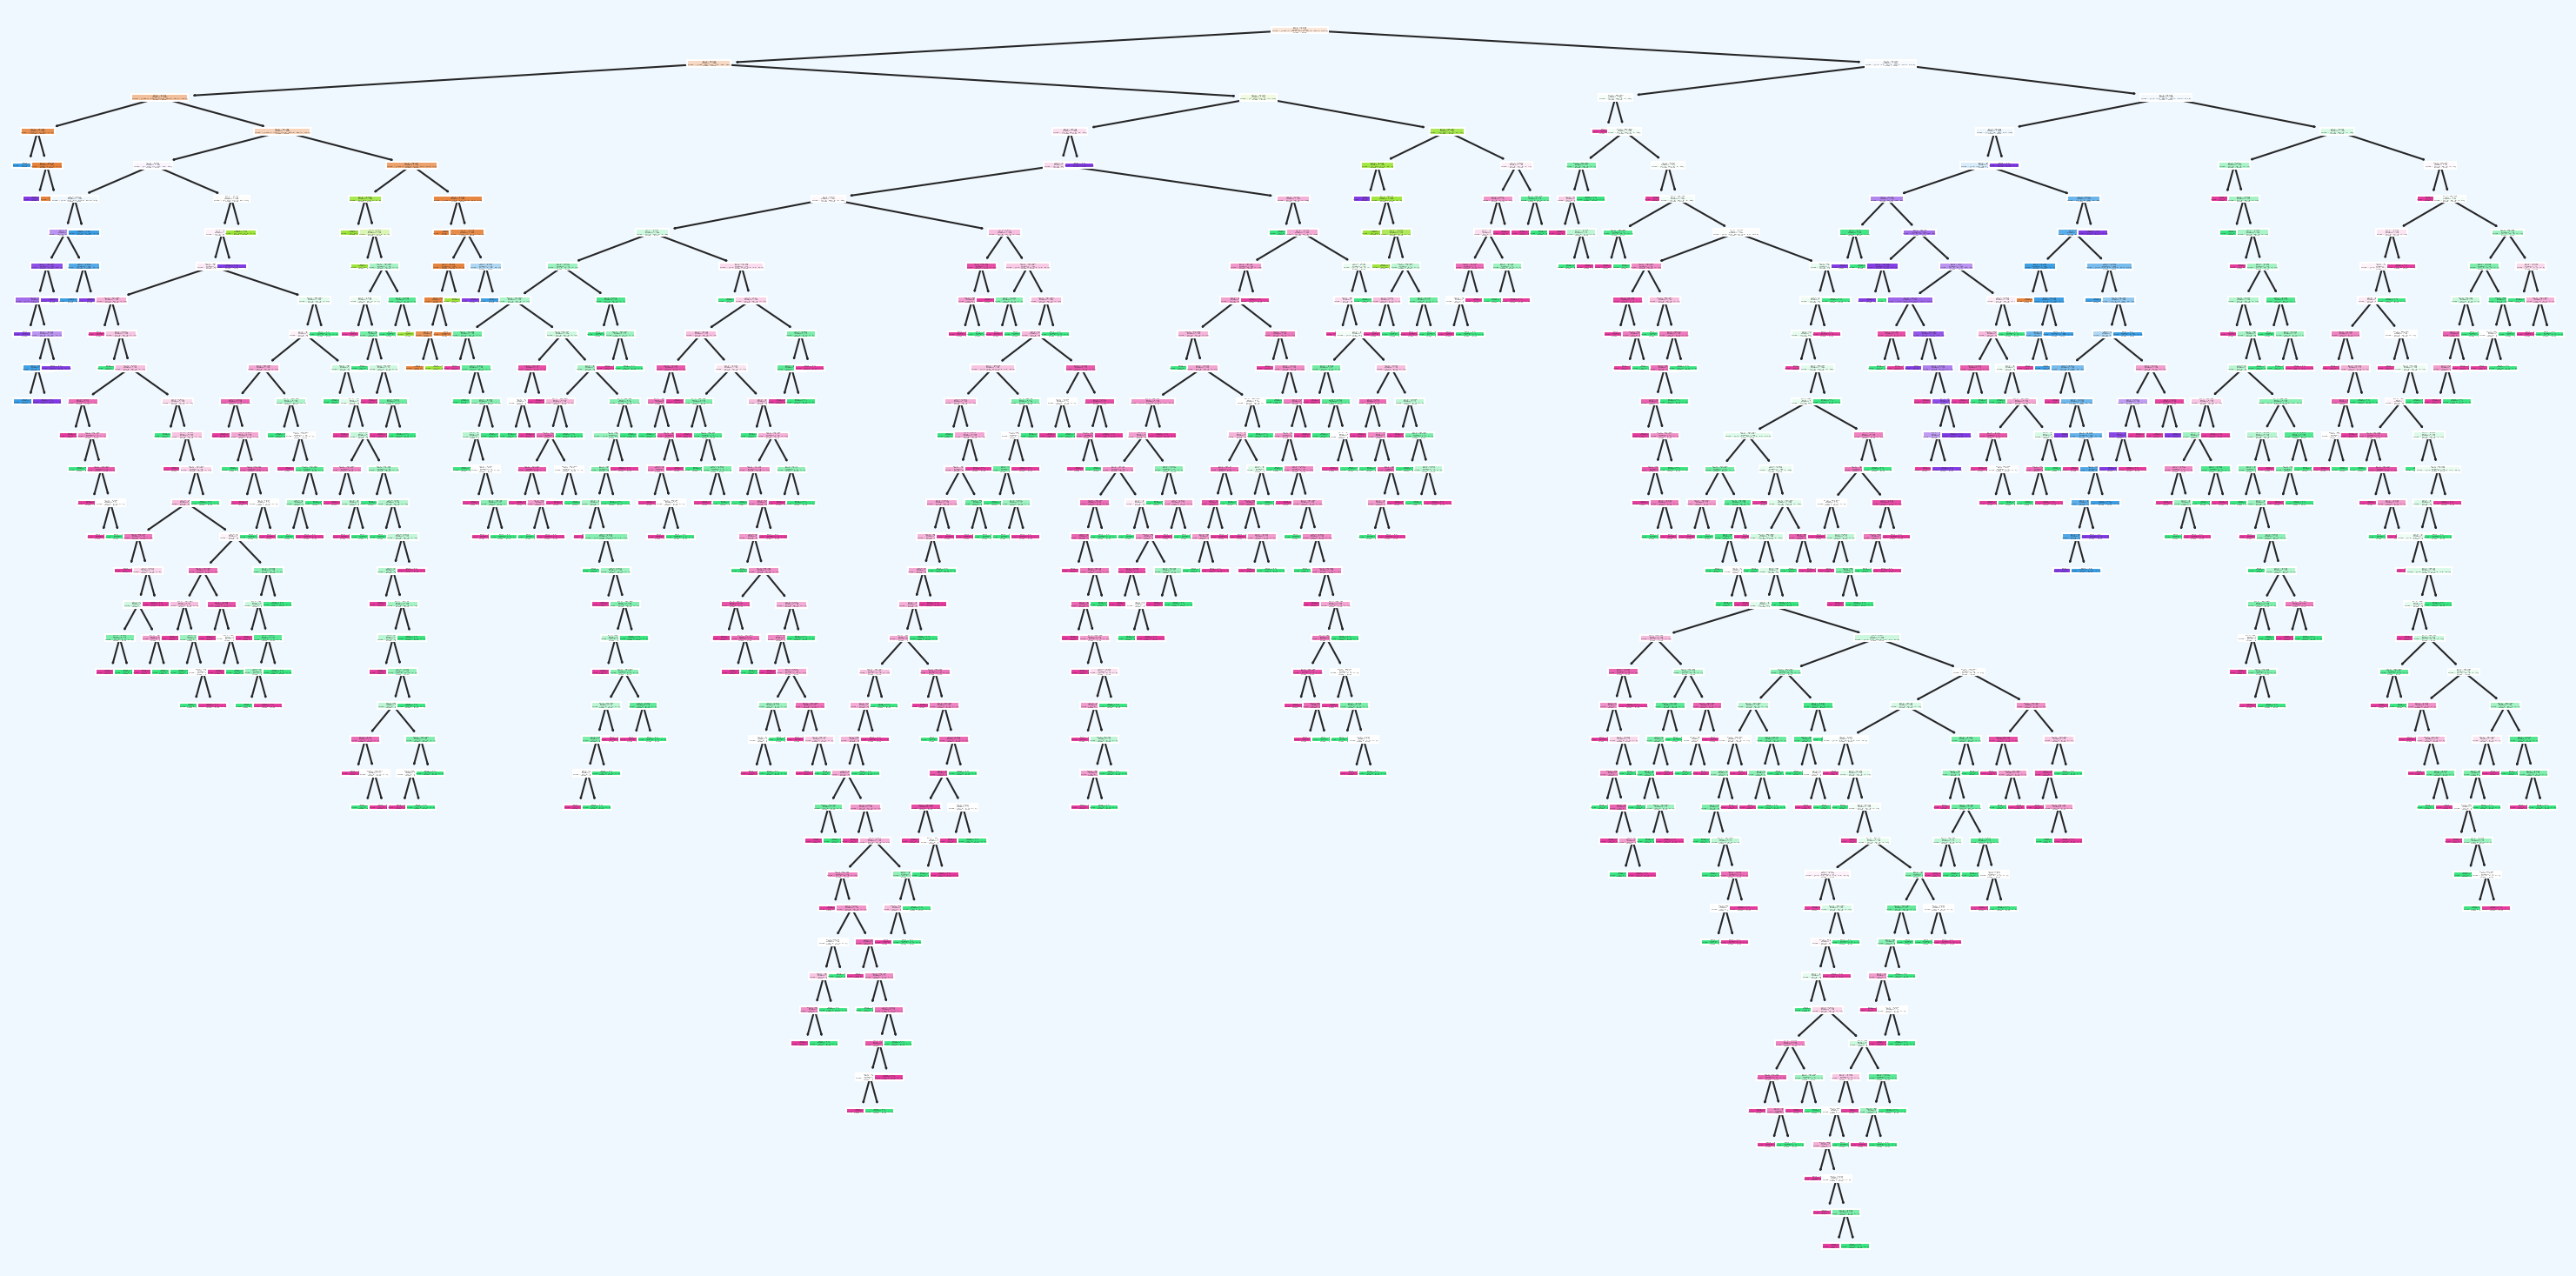

In [81]:
from sklearn.tree import plot_tree

# Choose a tree from the Random Forest
tree_number = 0  # index of the tree to visualize
plt.figure(figsize=(20, 10))
plot_tree(best_rf_model.named_steps['clf'].estimators_[tree_number], filled=True, feature_names=X.columns, class_names=le.classes_)
plt.show()


Пытаемся сделать лучше - используем реккурентные нейронные сети


1. Изменяем входные данные, чтобы они соответствовали требованиям RNN, которые ожидают входные данные в форме (batch_size, временные шаги, input_dim).


2. определяем простую модель RNN с одним слоем RNN, за которым следует пара полностью связанных (плотных) слоев.


3. компилируем модель с соответствующим оптимизатором, функцией потерь и метриками.


4. обучаем модель RNN на обучающих данных и оцениваем ее производительность на тестовых данных.


In [82]:
# Encoding fault types
multi_data['faultType'] = multi_data['G'].astype(str) + multi_data['C'].astype(str) + multi_data['B'].astype(str) + multi_data['A'].astype(str)

# Split features and target
X = multi_data.drop(['G','C','B','A','faultType'], axis=1)
y = multi_data['faultType']

# Encode target labels
le = LabelEncoder()
y = le.fit_transform(y)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

# Preprocess data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape data for RNN input
X_train_rnn = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_rnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# Define RNN model
def create_rnn_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        layers.SimpleRNN(64, input_shape=input_shape),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Create RNN model
input_shape = X_train_rnn.shape[1:]
num_classes = len(np.unique(y_train))
rnn_model = create_rnn_model(input_shape, num_classes)

# Train RNN model
history = rnn_model.fit(X_train_rnn, y_train, epochs=50, batch_size=32, validation_split=0.1)

# Evaluate RNN model
rnn_test_loss, rnn_test_accuracy = rnn_model.evaluate(X_test_rnn, y_test)
print("RNN Test Accuracy:", rnn_test_accuracy)


Epoch 1/50
177/177 [==============================] - 2s 5ms/step - loss: 0.8078 - accuracy: 0.6985 - val_loss: 0.4666 - val_accuracy: 0.7806
Epoch 2/50
177/177 [==============================] - 1s 3ms/step - loss: 0.4042 - accuracy: 0.8046 - val_loss: 0.3534 - val_accuracy: 0.8092
Epoch 3/50
177/177 [==============================] - 1s 3ms/step - loss: 0.3460 - accuracy: 0.8221 - val_loss: 0.3333 - val_accuracy: 0.8347
Epoch 4/50
177/177 [==============================] - 1s 3ms/step - loss: 0.3215 - accuracy: 0.8182 - val_loss: 0.2976 - val_accuracy: 0.8506
Epoch 5/50
177/177 [==============================] - 1s 3ms/step - loss: 0.3026 - accuracy: 0.8265 - val_loss: 0.3035 - val_accuracy: 0.8331
Epoch 6/50
177/177 [==============================] - 1s 3ms/step - loss: 0.2982 - accuracy: 0.8335 - val_loss: 0.2733 - val_accuracy: 0.8537
Epoch 7/50
177/177 [==============================] - 1s 3ms/step - loss: 0.2866 - accuracy: 0.8376 - val_loss: 0.2711 - val_accuracy: 0.8474
Epoch 

# RNN Test Accuracy: 0.8518754243850708

И опять пытаемся - используем сети долгой краткосрочной памяти

1. изменяем входные данные, чтобы они соответствовали требованиям сетей LSTM, которые ожидают входные данные в форме (batch_size, timesteps, input_dim).


2. определяем модель LSTM с одним слоем LSTM, за которым следует пара полностью связанных (плотных) слоев.


3. компилируем модель с соответствующим оптимизатором, функцией потерь и метриками.

4. обучаем модель LSTM на обучающих данных и оцениваем ее производительность на тестовых данных.

In [83]:
# Encoding fault types
multi_data['faultType'] = multi_data['G'].astype(str) + multi_data['C'].astype(str) + multi_data['B'].astype(str) + multi_data['A'].astype(str)

# Split features and target
X = multi_data.drop(['G','C','B','A','faultType'], axis=1)
y = multi_data['faultType']

# Encode target labels
le = LabelEncoder()
y = le.fit_transform(y)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

# Preprocess data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape data for LSTM input
X_train_lstm = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_lstm = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# Define LSTM model
def create_lstm_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        layers.LSTM(64, input_shape=input_shape),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Create LSTM model
input_shape = X_train_lstm.shape[1:]
num_classes = len(np.unique(y_train))
lstm_model = create_lstm_model(input_shape, num_classes)

# Train LSTM model
history = lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, validation_split=0.1)

# Evaluate LSTM model
lstm_test_loss, lstm_test_accuracy = lstm_model.evaluate(X_test_lstm, y_test)
print("LSTM Test Accuracy:", lstm_test_accuracy)


Epoch 1/50
177/177 [==============================] - 9s 24ms/step - loss: 1.2902 - accuracy: 0.4676 - val_loss: 0.7059 - val_accuracy: 0.6566
Epoch 2/50
177/177 [==============================] - 2s 12ms/step - loss: 0.5955 - accuracy: 0.7286 - val_loss: 0.5104 - val_accuracy: 0.7456
Epoch 3/50
177/177 [==============================] - 1s 8ms/step - loss: 0.4610 - accuracy: 0.7819 - val_loss: 0.4284 - val_accuracy: 0.7711
Epoch 4/50
177/177 [==============================] - 1s 5ms/step - loss: 0.3956 - accuracy: 0.7945 - val_loss: 0.3650 - val_accuracy: 0.8092
Epoch 5/50
177/177 [==============================] - 1s 5ms/step - loss: 0.3720 - accuracy: 0.8028 - val_loss: 0.3781 - val_accuracy: 0.8124
Epoch 6/50
177/177 [==============================] - 1s 5ms/step - loss: 0.3505 - accuracy: 0.8118 - val_loss: 0.3465 - val_accuracy: 0.7838
Epoch 7/50
177/177 [==============================] - 1s 5ms/step - loss: 0.3322 - accuracy: 0.8136 - val_loss: 0.3265 - val_accuracy: 0.8140
Epoc

# LSTM Test Accuracy: 0.8556897640228271

Следующая попытка - использовать Метод k-ближайших соседей

1. используем KNeighboursClassifier от scikit-learn для классификации KNN.


2.  определяем конвейер, который включает стандартное масштабирование функций и классификатор KNN.


3. используем GridSearchCV для настройки гиперпараметров и поиска лучшей модели KNN.


4. оцениваем лучшую модель KNN на тестовых данных и распечатываем ее точность.

In [84]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


# Encoding fault types
multi_data['faultType'] = multi_data['G'].astype(str) + multi_data['C'].astype(str) + multi_data['B'].astype(str) + multi_data['A'].astype(str)

# Split features and target
X = multi_data.drop(['G','C','B','A','faultType'], axis=1)
y = multi_data['faultType']

# Encode target labels
le = LabelEncoder()
y = le.fit_transform(y)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

# Preprocess data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define KNN pipeline
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', KNeighborsClassifier())
])

# Define parameters for GridSearchCV
knn_parameters = {
    'clf__n_neighbors': [3, 5, 7],
    'clf__weights': ['uniform', 'distance'],
    'clf__p': [1, 2]
}

# Perform GridSearchCV
knn_grid_search = GridSearchCV(knn_pipeline, knn_parameters, cv=5, n_jobs=-1, verbose=1)
knn_grid_search.fit(X_train_scaled, y_train)

# Best KNN model
best_knn_model = knn_grid_search.best_estimator_

# Evaluate best KNN model
knn_test_accuracy = best_knn_model.score(X_test_scaled, y_test)
print("K-Nearest Neighbors Test Accuracy:", knn_test_accuracy)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
K-Nearest Neighbors Test Accuracy: 0.8741258741258742


# K-Nearest Neighbors Test Accuracy: 0.8741258741258742

Попытаемся улучшить K-Nearest Neighbors


1. определяем новую сетку параметров knn_parameters с разными значениями для n_neighbors, весов и p.


2. выполняем GridSearchCV с новой сеткой параметров, чтобы найти наилучшую комбинацию гиперпараметров.

3. оцениваем лучшую модель KNN на тестовых данных и распечатываем ее точность.

In [85]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


# Encoding fault types
multi_data['faultType'] = multi_data['G'].astype(str) + multi_data['C'].astype(str) + multi_data['B'].astype(str) + multi_data['A'].astype(str)

# Split features and target
X = multi_data.drop(['G','C','B','A','faultType'], axis=1)
y = multi_data['faultType']

# Encode target labels
le = LabelEncoder()
y = le.fit_transform(y)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

# Preprocess data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define KNN pipeline
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', KNeighborsClassifier())
])

# Define parameters for GridSearchCV
knn_parameters = {
    'clf__n_neighbors': [3, 5, 7, 9],
    'clf__weights': ['uniform', 'distance'],
    'clf__p': [1, 2]  # 1 for Manhattan distance, 2 for Euclidean distance
}

# Perform GridSearchCV
knn_grid_search = GridSearchCV(knn_pipeline, knn_parameters, cv=5, n_jobs=-1, verbose=1)
knn_grid_search.fit(X_train_scaled, y_train)

# Best KNN model
best_knn_model = knn_grid_search.best_estimator_

# Evaluate best KNN model
knn_test_accuracy = best_knn_model.score(X_test_scaled, y_test)
print("Updated K-Nearest Neighbors Test Accuracy:", knn_test_accuracy)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Updated K-Nearest Neighbors Test Accuracy: 0.8741258741258742


# Updated K-Nearest Neighbors Test Accuracy: 0.8741258741258742

Попытаемся улчшить LSTM

1. добавляем двунаправленный слой LSTM с 64 блоками, который обрабатывает входные последовательности как в прямом, так и в обратном направлении.


2. включаем регуляризацию отсева с коэффициентом отсева 0,2 после двунаправленного слоя LSTM, чтобы предотвратить переобучение.


3. используем еще один слой LSTM с 64 единицами после слоя исключения, чтобы фиксировать дополнительные временные зависимости.


В остальном архитектура осталась такой же, как и раньше.

In [86]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras import layers


# Encoding fault types
multi_data['faultType'] = multi_data['G'].astype(str) + multi_data['C'].astype(str) + multi_data['B'].astype(str) + multi_data['A'].astype(str)

# Split features and target
X = multi_data.drop(['G','C','B','A','faultType'], axis=1)
y = multi_data['faultType']

# Encode target labels
le = LabelEncoder()
y = le.fit_transform(y)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

# Preprocess data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape data for LSTM input
X_train_lstm = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_lstm = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# Define LSTM model with dropout regularization and bidirectional LSTM layer
def create_lstm_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        layers.Bidirectional(layers.LSTM(64, return_sequences=True), input_shape=input_shape),
        layers.Dropout(0.2),
        layers.LSTM(64),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Create LSTM model
input_shape = X_train_lstm.shape[1:]
num_classes = len(np.unique(y_train))
lstm_model = create_lstm_model(input_shape, num_classes)

# Train LSTM model
history = lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, validation_split=0.1)

# Evaluate LSTM model
lstm_test_loss, lstm_test_accuracy = lstm_model.evaluate(X_test_lstm, y_test)
print("Updated LSTM Test Accuracy:", lstm_test_accuracy)


Epoch 1/50
177/177 [==============================] - 10s 20ms/step - loss: 1.1359 - accuracy: 0.5086 - val_loss: 0.6662 - val_accuracy: 0.6645
Epoch 2/50
177/177 [==============================] - 2s 13ms/step - loss: 0.6376 - accuracy: 0.6888 - val_loss: 0.5122 - val_accuracy: 0.7679
Epoch 3/50
177/177 [==============================] - 4s 21ms/step - loss: 0.5067 - accuracy: 0.7515 - val_loss: 0.5282 - val_accuracy: 0.7568
Epoch 4/50
177/177 [==============================] - 2s 13ms/step - loss: 0.4429 - accuracy: 0.7837 - val_loss: 0.4263 - val_accuracy: 0.7711
Epoch 5/50
177/177 [==============================] - 2s 13ms/step - loss: 0.4147 - accuracy: 0.7857 - val_loss: 0.3941 - val_accuracy: 0.7901
Epoch 6/50
177/177 [==============================] - 2s 13ms/step - loss: 0.3768 - accuracy: 0.8092 - val_loss: 0.3298 - val_accuracy: 0.8267
Epoch 7/50
177/177 [==============================] - 2s 14ms/step - loss: 0.3811 - accuracy: 0.7989 - val_loss: 0.3914 - val_accuracy: 0.774

# Updated LSTM Test Accuracy: 0.838525116443634

Попытаемся подобрать параметры LSTM

1. определяем функцию create_lstm_model для создания модели LSTM с настраиваемыми гиперпараметрами, такими как количество модулей LSTM и процент отсева.


2. экспериментируем с различными значениями lstm_units (количество модулей LSTM) и dropout_rate (скорость отсева), чтобы изучить различные архитектуры моделей.


3.  обучаем и оцениваем модель LSTM для каждой комбинации гиперпараметров и выбираем ту, которая имеет наибольшую точность теста.

In [87]:
# Encoding fault types
multi_data['faultType'] = multi_data['G'].astype(str) + multi_data['C'].astype(str) + multi_data['B'].astype(str) + multi_data['A'].astype(str)

# Split features and target
X = multi_data.drop(['G','C','B','A','faultType'], axis=1)
y = multi_data['faultType']

# Encode target labels
le = LabelEncoder()
y = le.fit_transform(y)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

# Preprocess data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape data for LSTM input
X_train_lstm = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_lstm = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# Define LSTM model with adjustable hyperparameters and architecture
def create_lstm_model(input_shape, num_classes, lstm_units=64, dropout_rate=0.2):
    model = tf.keras.Sequential([
        layers.LSTM(lstm_units, input_shape=input_shape, return_sequences=True),
        layers.Dropout(dropout_rate),
        layers.LSTM(lstm_units),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Experiment with different hyperparameters and model architecture
lstm_units_list = [32, 64, 128]
dropout_rate_list = [0.2, 0.3, 0.4]

best_accuracy = 0
best_hyperparameters = {}

for lstm_units in lstm_units_list:
    for dropout_rate in dropout_rate_list:
        print(f"Testing LSTM units: {lstm_units}, Dropout rate: {dropout_rate}")

        # Create LSTM model
        lstm_model = create_lstm_model(input_shape=X_train_lstm.shape[1:], num_classes=len(np.unique(y_train)),
                                       lstm_units=lstm_units, dropout_rate=dropout_rate)

        # Train LSTM model
        history = lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=0)

        # Evaluate LSTM model
        _, test_accuracy = lstm_model.evaluate(X_test_lstm, y_test, verbose=0)

        print(f"Test Accuracy: {test_accuracy}")
        print("------------------------------------------------------")

        # Update best hyperparameters if the accuracy improves
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            best_hyperparameters = {'lstm_units': lstm_units, 'dropout_rate': dropout_rate}

print("Best Hyperparameters:", best_hyperparameters)
print("Best Test Accuracy:", best_accuracy)


Testing LSTM units: 32, Dropout rate: 0.2
Test Accuracy: 0.8340750336647034
------------------------------------------------------
Testing LSTM units: 32, Dropout rate: 0.3
Test Accuracy: 0.8283534646034241
------------------------------------------------------
Testing LSTM units: 32, Dropout rate: 0.4
Test Accuracy: 0.8302606344223022
------------------------------------------------------
Testing LSTM units: 64, Dropout rate: 0.2
Test Accuracy: 0.8467895984649658
------------------------------------------------------
Testing LSTM units: 64, Dropout rate: 0.3
Test Accuracy: 0.8442466855049133
------------------------------------------------------
Testing LSTM units: 64, Dropout rate: 0.4
Test Accuracy: 0.8315321207046509
------------------------------------------------------
Testing LSTM units: 128, Dropout rate: 0.2
Test Accuracy: 0.8308963775634766
------------------------------------------------------
Testing LSTM units: 128, Dropout rate: 0.3
Test Accuracy: 0.8474252820014954
-----

В результате берем параметры наилучшего значения
 LSTM units: 128, Dropout rate: 0.4

Моделируем получившееся лучшее значение параметров  LSTM


In [88]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Encoding fault types
multi_data['faultType'] = multi_data['G'].astype(str) + multi_data['C'].astype(str) + multi_data['B'].astype(str) + multi_data['A'].astype(str)

# Split features and target
X = multi_data.drop(['G','C','B','A','faultType'], axis=1)
y = multi_data['faultType']

# Encode target labels
le = LabelEncoder()
y = le.fit_transform(y)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

# Preprocess data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape data for LSTM input (assuming X has a sequential nature, e.g., time series)
X_train_lstm = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_lstm = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# Define LSTM model with best hyperparameters
lstm_units = 128
dropout_rate = 0.4

model = tf.keras.Sequential([
    layers.LSTM(lstm_units, input_shape=X_train_lstm.shape[1:], return_sequences=True),
    layers.Dropout(dropout_rate),
    layers.LSTM(lstm_units),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(np.unique(y)), activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train_lstm, y_train, epochs=100, batch_size=32, validation_split=0.1)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_lstm, y_test)
print("Test Accuracy:", test_accuracy)




Epoch 1/100
177/177 [==============================] - 10s 27ms/step - loss: 1.2100 - accuracy: 0.5118 - val_loss: 0.7338 - val_accuracy: 0.6932
Epoch 2/100
177/177 [==============================] - 4s 21ms/step - loss: 0.6722 - accuracy: 0.7100 - val_loss: 0.6072 - val_accuracy: 0.7313
Epoch 3/100
177/177 [==============================] - 6s 31ms/step - loss: 0.5485 - accuracy: 0.7447 - val_loss: 0.4895 - val_accuracy: 0.7679
Epoch 4/100
177/177 [==============================] - 4s 21ms/step - loss: 0.4807 - accuracy: 0.7763 - val_loss: 0.4025 - val_accuracy: 0.8156
Epoch 5/100
177/177 [==============================] - 4s 21ms/step - loss: 0.4423 - accuracy: 0.7853 - val_loss: 0.3922 - val_accuracy: 0.7870
Epoch 6/100
177/177 [==============================] - 6s 31ms/step - loss: 0.4155 - accuracy: 0.7943 - val_loss: 0.4093 - val_accuracy: 0.7790
Epoch 7/100
177/177 [==============================] - 4s 21ms/step - loss: 0.4008 - accuracy: 0.7955 - val_loss: 0.4335 - val_accuracy

# Updated LSTM units: 128, Dropout rate: 0.4 Test Accuracy :  0.853782594203949


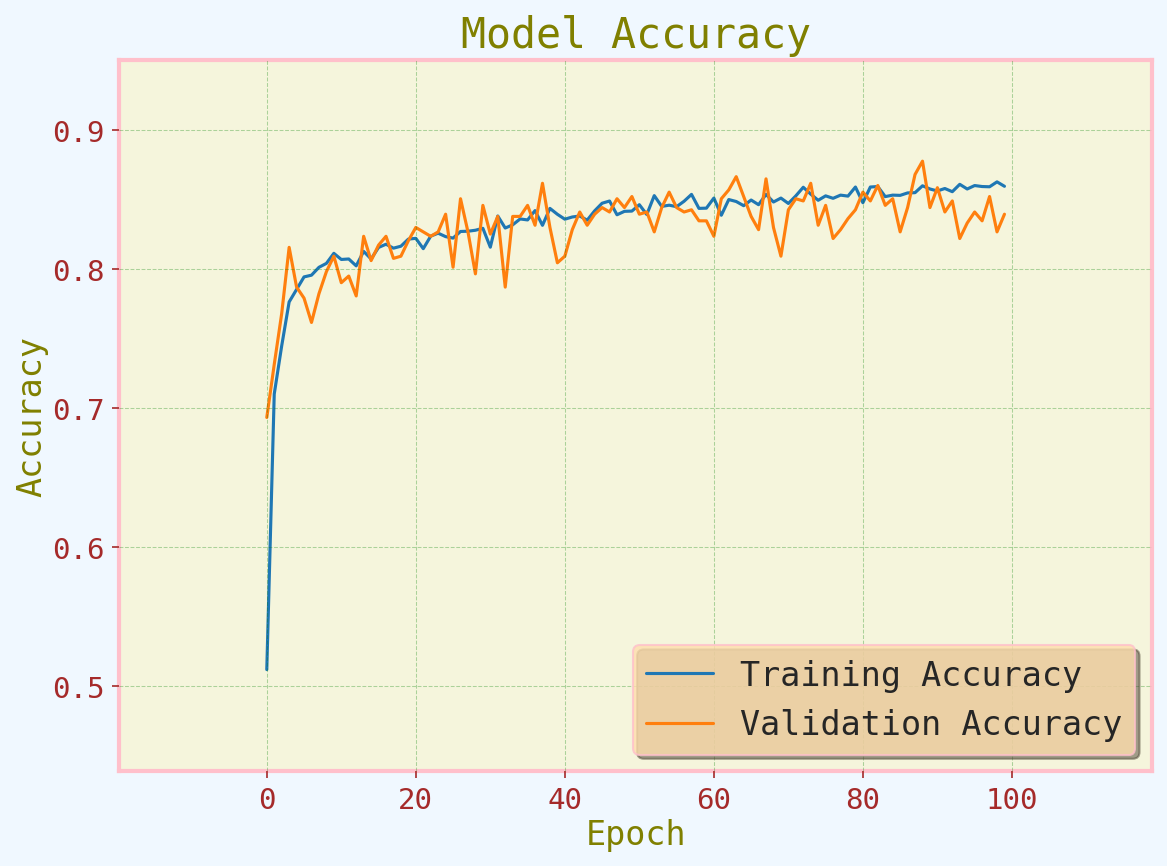

In [89]:
# Plot training history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure(figsize=(8, 6))

plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# **ВЫВОДЫ**

Рассмотрены различные более сложные модели. Первоначально полученный результат улучшить не удалось. Наилучшую точность показывает алгоритм случайного леса с подбором параметров и к-ближайших средних.

*   Random Forest + GridSearchCV  Test Accuracy: **0.8779402415766052**
*   Neural Network Test Accuracy: 0.8550540208816528

*   RNN Test Accuracy: 0.8518754243850708
*   LSTM Test Accuracy: 0.8556897640228271

*   Updated LSTM Test Accuracy: 0.838525116443634
*   Updated LSTM units: 128, Dropout rate: 0.4 Test Accuracy : 0.0.853782594203949

*   K-Nearest Neighbors Test Accuracy: **0.8741258741258742**
*   Updated K-Nearest Neighbors Test Accuracy: 0.8741258741258742


















